## Evaluating the system performance

This notebook evaluates the performance of the system by comparing the ranked list of pieces with the ground truth for each query.

In [6]:
%matplotlib inline

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
import pickle
import random
import pandas as pd
import seaborn as sns
#import pickle5
import itertools
import glob
import time
import matplotlib.patches as mpatches

In [9]:
FIG_X_SIZE = 16
FIG_Y_SIZE = 10
AXIS_LABEL_SIZE = 20
TICK_LABEL_SIZE = 15
LEGEND_LABEL_SIZE = 20

In [10]:
def readGroundTruthLabels(gtfile):
    d={}
    d1={}
    with open(gtfile, "r") as f:
        for line in f:
            data = line.split(',')
            key = data[0]
            d[key] = []
            d1[key] = key
            for idx,item in enumerate(data):
                if idx != 0 and item != "x":
                    try:
                        pieceNum = int(item)
                        d[key].append(pieceNum)
                    except:
                        pass
                    try:
                        pieceNum = int(item)
                        d1[str(pieceNum)] = key
                    except:
                        pass
    return d, d1

In [11]:
def readHypothesisFiles(hypdir, benchmark):
    l = []
    for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
#         print(hypfile)
        with open(hypfile, "rb") as f:
            l.append(pickle.load(f))
    return l

In [12]:
s = set([])
def collapseIds(pieceScores):
    pieceScores = list(dict.fromkeys(pieceScores))
    return pieceScores
        

In [13]:
def getRank(pieceScores,gt,idt,queryid, condition):
    query = queryid.split('_')[0]
    l = []
    count = 0
    rank = 300000
    for i in range(len(pieceScores)):
        if pieceScores[i][0][0]=='p':
            if(pieceScores[i][0]==queryid.split('_')[0]):
                rank=count+1
                return rank
            if not pieceScores[i][0] in idt.keys():
                count+=1
            elif not idt[pieceScores[i][0]] in l:
                count+=1
                l.append(idt[idt[pieceScores[i][0]]])
        else:
            try:
                if (int(pieceScores[i][0].split("_")[-1]) in gt[query]):
                    rank = count+1
                    return rank

                if not str(int(pieceScores[i][0].split("_")[-1])) in idt.keys():
                    count+=1
                elif not idt[str(int(pieceScores[i][0].split("_")[-1]))] in l:
                    count+=1
                    l.append(idt[str(int(pieceScores[i][0].split("_")[-1]))])
            except:
                pass
    return rank

In [14]:
def calcPrecisionRecall(hypdir, gtfile, benchmark = False, condition = 1):
    """Inputs: a directory containing the ranked list of pieces from the marketplace fingerprinting system,
               and a file containing the ground truth mapping for each query and the correct IMSLP piece.
               
       Outputs: the MRR for all the predictions, a list of ranks for each query, a list of runtimes for 
                each query, and the number of matches processed for each query."""
    hyps = readHypothesisFiles(hypdir, benchmark)
    gt,idt = readGroundTruthLabels(gtfile)
    MRR = 0
    runtimes = []
    MRRs = []
    matches = []
    hyps = np.array(sorted(hyps, key = lambda x: int(x[0].split("_")[0][1:])*100+int(x[0].split("_")[1][1:])), dtype=object)
    count = 0
    print(hyps.shape)
    if hyps.shape[1] == 2:
        for queryid, pieceScores in hyps:
            rank = getRank(pieceScores,gt,idt,queryid, condition)
            MRRs.append((queryid,rank))
            MRR=MRR+1/(rank)
    else:
        for queryid, pieceScores, runtime, matches_processed in hyps:
            rank = getRank(pieceScores,gt,idt,queryid, condition)
            MRRs.append((queryid,rank))
            runtimes.append(runtime)
            MRR=MRR+1/(rank)
            matches.append(matches_processed)
    return MRR/len(MRRs),MRRs, runtimes, matches

In [15]:
def calcOverlap(seg1, seg2):
    overlap_lb = max(seg1[0], seg2[0])
    overlap_ub = min(seg1[1], seg2[1])
    overlap = np.clip(overlap_ub - overlap_lb, 0, None)
    return overlap    

In [10]:
runtime_budgets_all = np.round(10**np.linspace(1.8,6,50)).astype(int)

In [11]:
runtime_budget = runtime_budgets_all[42]
print(runtime_budget)

251189


In [28]:
runtime_budget

251189

In [29]:
hypdir = 'experiments/v0.4.0d_test_' + str(runtime_budget)+'_budget/hyp'
benchmark = 0
queryGTFile = 'piece_To_id.csv'
correct_matches = {}
MRR, MRRs, runtimes, matches_processed = calcPrecisionRecall(hypdir, queryGTFile, benchmark, condition = 1)

(0,)


IndexError: tuple index out of range

In [30]:
hyps = readHypothesisFiles(hypdir, benchmark)

In [31]:
hyps = np.array(sorted(hyps, key = lambda x: int(x[0].split("_")[0][1:])*100+int(x[0].split("_")[1][1:])), dtype=object)

In [32]:
queryid, pieceScores, runtime, all_matches_processed = hyps[12]
gt,idt = readGroundTruthLabels(queryGTFile)
query = queryid.split('_')[0]

IndexError: index 12 is out of bounds for axis 0 with size 0

### Investigate Errors

This prints the individual ranks for each query.

In [33]:
def printDebuggingInfo(MRRs):
    for i, (queryid, rank) in enumerate(MRRs):
        print(queryid, rank)

In [34]:
maxRunInd = np.argmax(runtimes)

NameError: name 'runtimes' is not defined

In [35]:
maxRunInd

NameError: name 'maxRunInd' is not defined

In [36]:
runtimes[maxRunInd]

NameError: name 'runtimes' is not defined

In [37]:
MRRs[maxRunInd]

NameError: name 'MRRs' is not defined

In [38]:
printDebuggingInfo(MRRs)

NameError: name 'MRRs' is not defined

### Measure Runtime

In [39]:
def showRuntimeStats(durs):
    durs = np.array(durs)
    avgDur = np.mean(durs)
    minDur = np.min(durs)
    maxDur = np.max(durs)
    stdDur = np.std(durs)
    print('Avg runtime: {:.2f} sec'.format(avgDur))
    print('Std runtime: {:.2f} sec'.format(stdDur))
    print('Min runtime: {:.2f} sec'.format(minDur))
    print('Max runtime: {:.2f} sec'.format(maxDur))
    plt.hist(durs, bins=np.arange(0,2,.1))
    plt.xlabel('Runtime (sec)')
    plt.ylabel('Count')

In [40]:
showRuntimeStats(runtimes)

NameError: name 'runtimes' is not defined

### Measure matches processed

In [ ]:
def showMatchStats(matchesProcessed):
    matches = np.array(matchesProcessed)
    avgMatches = np.mean(matches)
    minMatches = np.min(matches)
    maxMatches = np.max(matches)
    stdMatches = np.std(matches)
    print(f'Avg matches: {avgMatches}')
    print(f'Std matches: {stdMatches}')
    print(f'Min matches: {minMatches}')
    print(f'Max matches: {maxMatches}')
    plt.hist(matches)
    plt.xlabel('Number of matches processed')
    plt.ylabel('Count')

In [41]:
showMatchStats(matches_processed)

NameError: name 'showMatchStats' is not defined

# Analysis Plot 1: Effect of runtime budget

In [12]:
def evalDir(hypdir):
    benchmark = 0
    queryGTFile = 'piece_To_id.csv'
    correct_matches = {}
    MRR, MRRs, runtimes, all_matches_processed = calcPrecisionRecall(hypdir, queryGTFile, benchmark, condition = 1)
    all_matches_processed = np.array([np.cumsum(np.array(x)) for x in all_matches_processed], dtype = object)
    return MRR, MRRs, runtimes, all_matches_processed

In [43]:
runtime_budgets = np.round(10**np.linspace(1.8,6,50)).astype(int)

print(runtime_budgets)

[     63      77      94     114     139     169     206     251     306
     373     454     553     674     821    1000    1218    1484    1808
    2202    2683    3268    3981    4850    5908    7197    8767   10680
   13010   15849   19307   23520   28651   34903   42518   51795   63096
   76862   93633  114062  138950  169267  206199  251189  305995  372759
  454091  553168  673863  820891 1000000]


In [247]:
valid_runtime_budgets = [runtime_budgets[-1]]

In [248]:
valid_runtime_budgets

[1000000]

In [250]:
# dataToDrop = valid_runtime_budgets

# for RTBEntry in dataToDrop:
#     MRRData = MRRData[MRRData['runtimeBudget'] != RTBEntry]
#     RTData = RTData[RTData['runtimeBudget'] != RTBEntry]

In [251]:
# MRRData = pd.DataFrame(columns = list(['runtimeBudget', 'MRR']))
# RTData = pd.DataFrame(columns = list(['runtimeBudget', 'runtime']))

# for runtime_budget in valid_runtime_budgets:

#     dirName = 'experiments/RTB/v0.4.0d_test_' + str(runtime_budget) + '_budget/hyp'
    
    
#     MRR, MRRs, runtimes, all_matches_processed = evalDir(dirName)
    
    
    
#     SingleMRRData = pd.DataFrame([[runtime_budget, MRR]], columns = ['runtimeBudget', 'MRR'])
#     MRRData = MRRData.append(SingleMRRData, ignore_index = True)
    
#     SingleRTData = pd.DataFrame(list(np.array([[runtime_budget] * len(runtimes), runtimes]).T), columns = ['runtimeBudget', 'runtime'])
#     RTData = RTData.append(SingleRTData, ignore_index = True)
    
#     print(dirName)

(1597, 4)
experiments/RTB/v0.4.0d_test_1000000_budget/hyp


In [ ]:
# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot1Marketplace.pkl', 'wb') as plotFile:
#     pickle.dump((MRRData,RTData),plotFile)

In [44]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot1Marketplace.pkl', 'rb') as plotFile:
    MRRData, RTData = pickle.load(plotFile)

In [46]:
MRRData

,runtimeBudget,MRR
0,63,0.107882
1,77,0.216932
2,94,0.365440
3,114,0.565793
4,139,0.740557
5,169,0.837096
6,206,0.859315
7,251,0.869726
8,306,0.877151
9,373,0.885220


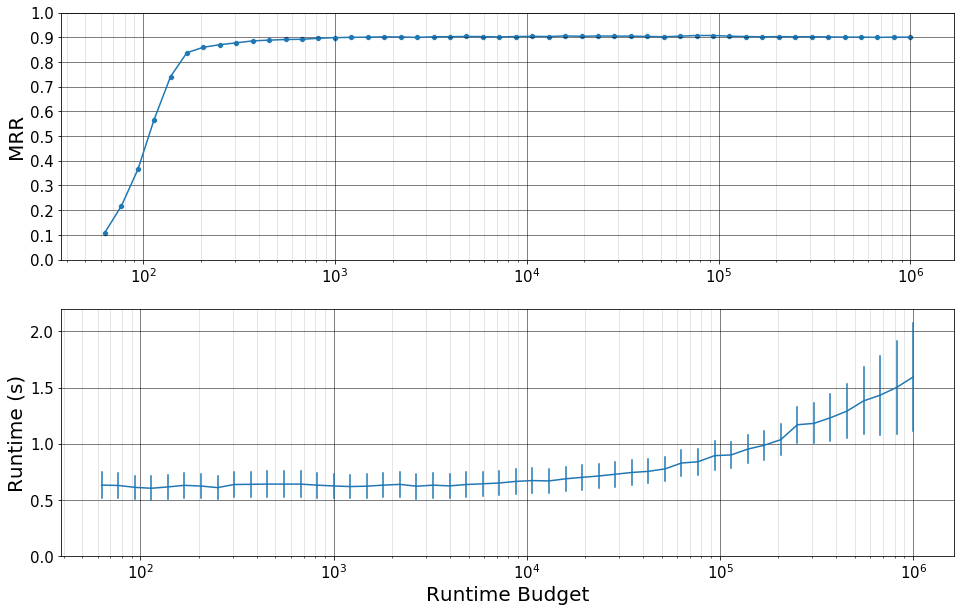

In [45]:
fig, ax = plt.subplots(2, 1, figsize = (FIG_X_SIZE,FIG_Y_SIZE))
#plt.tight_layout()

ax[0].set(xscale="log")
ax[0].set_ylim(0,1)
ax[0].set_yticks(np.linspace(0,1,11))
ax[0].grid(b=True, which='minor', color='black', linestyle='-', linewidth = 0.5, alpha = 0.2)
ax[0].grid(b=True, which='major', color='black', linestyle='-', linewidth = 1, alpha = 0.5)
sns.lineplot(ax = ax[0], x = 'runtimeBudget', y = 'MRR', data = MRRData)
sns.scatterplot(ax = ax[0], x = 'runtimeBudget', y = 'MRR', data = MRRData)
ax[0].set_ylabel('MRR', fontsize = AXIS_LABEL_SIZE)
ax[0].set_xlabel(' ', fontsize = AXIS_LABEL_SIZE)

ax[0].tick_params(axis='x', labelsize= TICK_LABEL_SIZE)
ax[0].tick_params(axis='y', labelsize= TICK_LABEL_SIZE)


ax[1].set(xscale="log")
ax[1].set_ylim(0,2.2)
sns.lineplot(ax = ax[1], x = 'runtimeBudget', y = 'runtime', ci = 'sd', err_style = 'bars', data = RTData)
#sns.scatterplot(ax = ax[1], x = 'runtimeBudget', y = 'runtime', ci = 'sd', data = RTData)
ax[1].set_ylabel('Runtime (s)', fontsize = AXIS_LABEL_SIZE)
ax[1].set_xlabel('Runtime Budget', fontsize = AXIS_LABEL_SIZE)
ax[1].grid(b=True, which='minor', color='black', linestyle='-', linewidth = 0.5, alpha = 0.2)
ax[1].grid(b=True, which='major', color='black', linestyle='-', linewidth = 1, alpha = 0.5)

ax[1].tick_params(axis='x', labelsize= TICK_LABEL_SIZE)
ax[1].tick_params(axis='y', labelsize= TICK_LABEL_SIZE)

plt.show()

In [233]:
print(runtime_budget)

1000000


In [234]:
maxRunInd = np.argmax(runtimes)

In [235]:
maxRunInd

21

In [236]:
runtimes[maxRunInd]

53.76364612579346

In [239]:
MRRs[1087]

('p138_q1', 1)

In [238]:
runTimesForBudget = [ [i,x] for i,x in enumerate(RTData[RTData['runtimeBudget'] == valid_runtime_budgets[0]].values[:,1])]
sortedRTForB = sorted(runTimesForBudget,key=lambda x: x[1])
print(sortedRTForB[-10:])

[[767, 2.503783702850342], [450, 2.5328052043914795], [1231, 2.5490522384643555], [975, 2.580695629119873], [1023, 2.5904221534729004], [769, 2.6136763095855713], [1425, 2.637225866317749], [1426, 2.6913344860076904], [1087, 46.19821381568909], [21, 53.76364612579346]]


# Analysis Plot 2: Runtime Analysis

In [12]:
def runTimeAnalysis(all_matches_processed, system):
    lookupData = pd.DataFrame(columns = ['testBenchmarkNum', 'numLookups', 'system', 'matchesProcessed'])

    for tbNum, matches_over_time in enumerate(all_matches_processed):
        if(tbNum % 20 == 0):
            print(tbNum)
        matches_DF = pd.DataFrame({'testBenchmarkNum': np.ones(matches_over_time.shape) * tbNum,
                    'numLookups' : np.arange(matches_over_time.shape[0]) + 1, 
                    'system': system, 
                    'matchesProcessed': matches_over_time})
        lookupData = lookupData.append(matches_DF, ignore_index = True)
    return lookupData

#### Creation of marketplace lookupData

In [13]:
# runtime_budget = 1000

# dirName = 'experiments/RTB/v0.4.0d_test_1000_budget/hyp'
# MRR, MRRs, runtimes, all_matches_processed = evalDir(dirName)

# print(runtime_budget)

# lookupData = runTimeAnalysis(all_matches_processed, 'marketplace')

# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot2Marketplace.pkl', 'wb') as plotFile:
#      pickle.dump(lookupData,plotFile)

#### Creation of dynamic lookupData

In [76]:
# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plotDynamic4GramIntermediate.pkl', 'rb') as plotFile:
#      MRR, MRRs, runtimes, all_matches_processed = pickle.load(plotFile)
        
# all_matches_processed = np.array([np.cumsum(np.array(x)) for x in all_matches_processed], dtype = object)

# lookupData = runTimeAnalysis(all_matches_processed, 'dynamic')

# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot2Dynamic.pkl', 'wb') as plotFile:
#      pickle.dump(lookupData,plotFile)

#### Reading in marketplace and dynamic lookupData

In [7]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot2Marketplace.pkl', 'rb') as plotFile:
     lookupDataMP = pickle.load(plotFile)

In [8]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot2Dynamic.pkl', 'rb') as plotFile:
     lookupDataDN = pickle.load(plotFile)

In [9]:
lookupData = lookupDataMP.append(lookupDataDN)

In [10]:
lookupData['numLookups'] = lookupData['numLookups'].astype(float)
lookupData['matchesProcessed'] = lookupData['matchesProcessed'].astype(float)

In [11]:
#np.median(lookupData[lookupData['system'] == 'marketplace'].groupby('testBenchmarkNum').max()['numLookups'].values)

In [72]:
def calcMeanTraj(lookupData, system):    
    meanEnd = np.median(lookupData[lookupData['system'] == system].groupby('testBenchmarkNum').max()['numLookups'].values)
    medianCheck = (lookupData[lookupData['system'] == system].groupby('testBenchmarkNum').max()['numLookups'] == meanEnd).values
    medianTrajNums = []
    for i, endBool in enumerate(medianCheck):
        if(endBool):
            medianTrajNums += [i]
    medianTrajs = lookupData[lookupData['testBenchmarkNum'].isin(medianTrajNums)]
    LDMean = medianTrajs[medianTrajs['system'] == system].groupby('numLookups').median()
    LDMean['numLookups'] = np.arange(LDMean.shape[0]) + 1
    
    LDMean['system'] = [system] * LDMean.shape[0]
    
    return LDMean

def plotRunTimeAnalysis(lookupData):
    
    MPLDMean = calcMeanTraj(lookupData, 'marketplace')

    DNLDMean = calcMeanTraj(lookupData, 'dynamic')
    
    LDMean = MPLDMean.append(DNLDMean)
    
    #lookupData = lookupData.sample(frac = 0.03)

    maxMPLookupData = lookupData[lookupData['system'] == 'marketplace'].groupby('testBenchmarkNum').max()
    maxDNLookupData = lookupData[lookupData['system'] == 'dynamic'].groupby('testBenchmarkNum').max()

    maxLookupData = maxMPLookupData.append(maxDNLookupData)

    fig, axes = plt.subplots(figsize = (FIG_X_SIZE,FIG_Y_SIZE))
    
    plotPalette = {'dynamic':'blue', 'marketplace':'green'}
    
    sns.scatterplot(data = maxLookupData, ax = axes, x = 'numLookups', y = 'matchesProcessed', 
    hue = 'system', markers = ['.','.'], palette = {'dynamic':'blue', 'marketplace':'green'}, alpha = 1, s = 30)
    
#     sns.lineplot(ax = axes, x="numLookups", y="matchesProcessed", hue="system",
#                 units = 'testBenchmarkNum', estimator = None, data=lookupData, palette = plotPalette, 
#                 alpha = 0.03);
    

    
#     meanPlot = sns.lineplot(ax = axes, x="numLookups", y="matchesProcessed", data=LDMean, hue = "system",
#            palette = {'dynamic':'red', 'marketplace':'orange'}, linewidth = 4.0, alpha = 1);

    plt.xticks(fontsize = TICK_LABEL_SIZE)
    plt.yticks(fontsize = TICK_LABEL_SIZE)
    plt.plot(np.arange(1000)*10,np.ones(1000)*1000, color = 'gray', linestyle = 'dashed')
    plt.setp(axes.lines, zorder=100)
    plt.setp(axes.collections, zorder=1)
    plt.grid()

    
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles=[handles[2],handles[1]], labels=['Dynamic N-Gram', 'Marketplace'], fontsize = LEGEND_LABEL_SIZE, loc = 4)
    
    axes.set_ylabel('Matches Processed', fontsize = AXIS_LABEL_SIZE)
    axes.set_xlabel('# N-gram Lookups', fontsize = AXIS_LABEL_SIZE)
    axes.set(yscale="log")
    axes.set(xscale="log")
    axes.set_xlim(0,5*10**3)
    
#     marketplaceLegend = mpatches.Patch(color='green', label='Marketplace')
#     dynamicLegend = mpatches.Patch(color='blue', label='Dynamic')
#     plt.legend(handles=[dynamicLegend,marketplaceLegend], fontsize = LEGEND_LABEL_SIZE)
    
    #plt.legend(['marketplace','dynamic'])

    plt.show()

/home/agoutam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


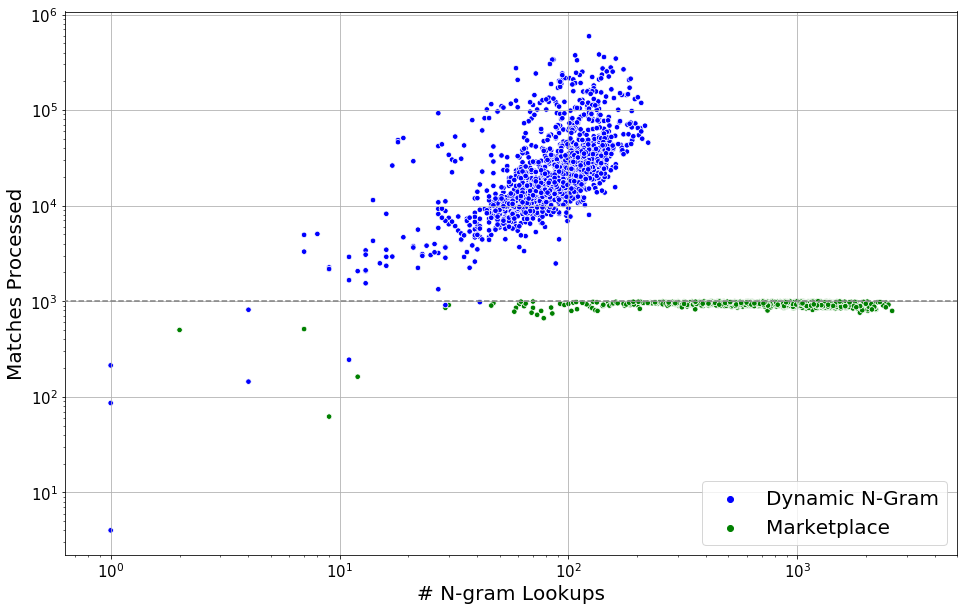

In [73]:
plotRunTimeAnalysis(lookupData)

In [71]:
# maxMPLookupData = lookupData[lookupData['system'] == 'marketplace'].groupby('testBenchmarkNum').max()
# maxDNLookupData = lookupData[lookupData['system'] == 'dynamic'].groupby('testBenchmarkNum').max()

# maxLookupData = maxMPLookupData.append(maxDNLookupData)

# fig, axes = plt.subplots(figsize = (FIG_X_SIZE,FIG_Y_SIZE))

# sns.scatterplot(data = maxLookupData, ax = axes, x = 'numLookups', y = 'matchesProcessed', 
#               hue = 'system', markers = ['.','.'])
# plt.xticks([])
# axes.set(yscale="log")
# #plt.xticks([100,200,500,1000],fontsize = TICK_LABEL_SIZE)

# plt.show()

# Analysis Plot 3: MRR Vs. RAM used

In [1]:
mpSizeTestDirs = glob.glob('/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/*')
mpSizeTestDirs = [x + '/hyp' for x in mpSizeTestDirs]
mpSizeTestDirs = sorted(mpSizeTestDirs)

NameError: name 'glob' is not defined

In [23]:
mpSizeTestDirs

['/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_0.12mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_0.135mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_0.69mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_1.5mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_103mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_18mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_2.2mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_26mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_38.18mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_4.17mil_size/hyp',
 '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_52mil_size/hyp',
 '/home/agoutam/ImprovedShee

In [24]:
# mpSizeTestDirs = ['/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_0.12mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_0.69mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_1.5mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_103mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_18mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_2.2mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_26mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_4.17mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_52mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_59mil_size/hyp',
#  '/home/agoutam/ImprovedSheetID/experiments/sizeRTB65000/v0.4.0d_test_5mil_size/hyp']

In [90]:
#TODO LOAD ALL DATABASES AND DOUBLE CHECK SIZES

mpSizeDictFPToGB = {'1.5mil':33.4,'2.2mil':36.7,'4.17mil':44.3,
                  '26mil':71.0,'59mil':95.99,'18mil':63.3,
                  '0.69mil': 18.7,'5mil': 44.7,'52mil':92.4,
                  '103mil':126.5, '0.12mil':15.99 # 0.12 is actually closer to 17
                 }

availableRAMS = [16, 32, 48, 64, 80, 96, 128]

In [ ]:
ramData = pd.DataFrame({"size":[],"system":[],"MRR":[]})

for testDir in mpSizeTestDirs:
    
    if(testDir.split('_')[-2] not in mpSizeDictFPToGB.keys()):
        print(testDir.split('_')[-2])
        continue
    size = mpSizeDictFPToGB[testDir.split('_')[-2]]
    
    MRR, MRRs, runtimes, all_matches_processed = evalDir(testDir)
    size = mpSizeDictFPToGB[testDir.split('_')[-2]]
    
    sizeInd = np.digitize(size, availableRAMS)
    print(size, sizeInd)
    ramData = ramData.append({'size':availableRAMS[sizeInd], 'system': 'Marketplace', 'MRR': MRR}, ignore_index = True)

In [89]:
ramData = ramData.groupby('size').mean()
ramData['size'] = ramData.index.values
ramData['system'] = ['marketplace'] * ramData.shape[0]

In [90]:
# ramData = pd.DataFrame({"size":[],"system":[],"MRR":[]})

# for testDir in mpSizeTestDirs:
#     MRR, MRRs, runtimes, all_matches_processed = evalDir(testDir)
#     size = mpSizeDictFPToGB[testDir.split('_')[-2]]
#     ramData = ramData.append({'size':size, 'system': 'Marketplace', 'MRR': MRR}, ignore_index = True)

In [80]:
mpDbSizes = np.sort(ramData['size'].values)

#dnDbSizes= np.array([5.03,18.71,44.4,80.4])
dnDbSizes= np.array([6.4,24.9,48.6,127.99])

In [81]:
dnMRR = [0.709, 0.858, 0.854, 0.853]

In [82]:
dnDir = '/home/agoutam/ImprovedSheetID/experiments/plotData'
#dnMRRFiles = [dnDir + '/plotDynamic' + str(x) + 'GramIntermediate.pkl' for x in range(1,5)]

In [83]:
ramData = ramData[ramData['system'] != 'Dynamic N-Gram']

for i, size in enumerate(mpDbSizes):
    print(i)
    #closestDnInd = np.argmin(np.abs(size - dnDbSizes))
    closestDnInd = np.digitize(size, dnDbSizes)

    with open(dnMRRFiles[closestDnInd-1], 'rb') as plotFile:
        MRR, MRRs, runtimes, all_matches_processed = [dnMRR[closestDnInd-1], 1, 1, 1]
        #MRR, MRRs, runtimes, all_matches_processed = pickle.load(plotFile)
    
    toPrepend = pd.DataFrame({'size':[size], 'system': ['Dynamic N-Gram'], 'MRR': [MRR]})
    
    ramData = toPrepend.append(ramData, ignore_index = True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [66]:
#ramData = ramData[ramData['system'] != 'Dynamic N-Gram']

In [84]:
ramData

,size,system,MRR
0,128.0,Dynamic N-Gram,0.853000
1,128.0,Dynamic N-Gram,0.853000
2,96.0,Dynamic N-Gram,0.854000
3,96.0,Dynamic N-Gram,0.854000
4,80.0,Dynamic N-Gram,0.854000
5,80.0,Dynamic N-Gram,0.854000
6,64.0,Dynamic N-Gram,0.854000
7,64.0,Dynamic N-Gram,0.854000
8,48.0,Dynamic N-Gram,0.858000
9,48.0,Dynamic N-Gram,0.858000


In [86]:
# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot3All.pkl', 'wb') as plotFile:
#     pickle.dump(ramData, plotFile)

In [78]:
# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot3All.pkl', 'rb') as plotFile:
#     ramData = pickle.load(plotFile)

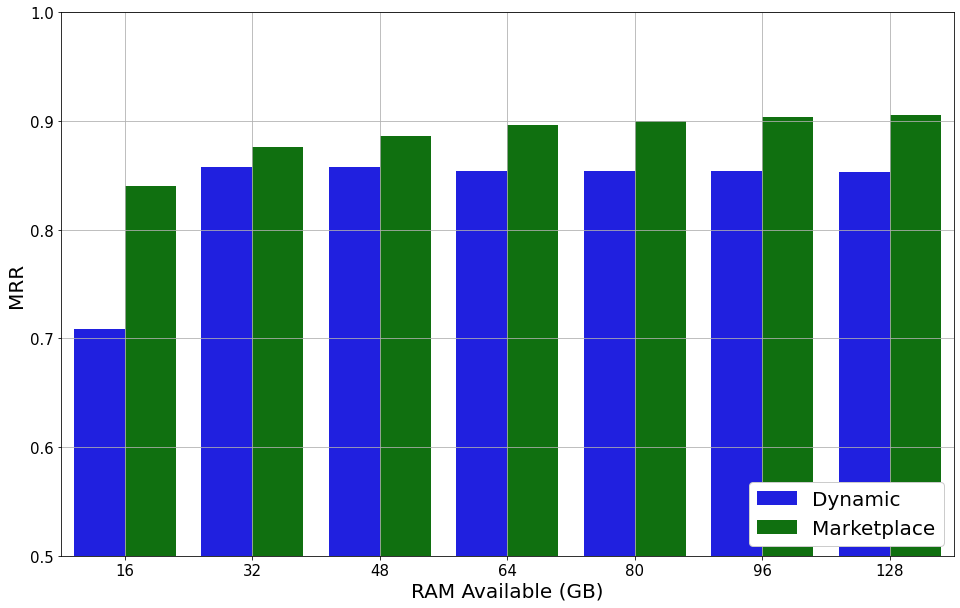

In [96]:
fig, axes = plt.subplots(figsize = (FIG_X_SIZE,FIG_Y_SIZE))

sns.barplot(ax = axes,
    data=ramData,
    x="size", y="MRR", hue="system", palette={'Dynamic N-Gram':'blue', 'marketplace':'green'}
)
axes.set_ylim(0.5,1)

axes.set_ylabel('MRR', fontsize = AXIS_LABEL_SIZE)
axes.set_xlabel('RAM Available (GB)', fontsize = AXIS_LABEL_SIZE)

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles=handles, labels=['Dynamic', 'Marketplace'], fontsize = LEGEND_LABEL_SIZE, loc = 4, framealpha = 1)

plt.xticks(np.arange(7),availableRAMS, fontsize = TICK_LABEL_SIZE)
plt.yticks(fontsize = TICK_LABEL_SIZE)
plt.grid()

plt.show()

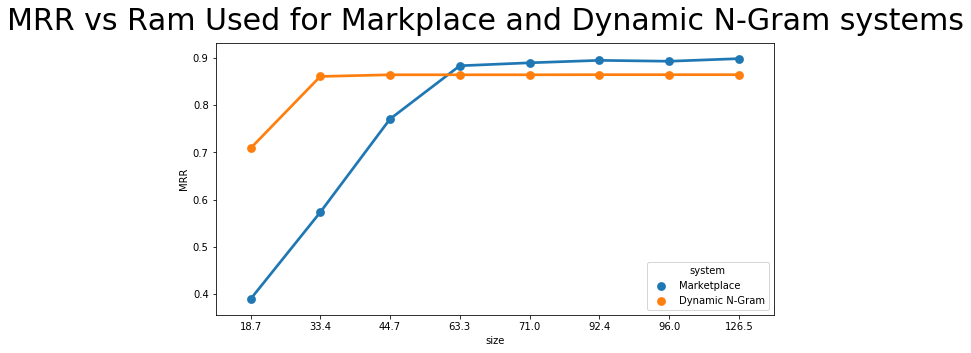

In [554]:
fig, axes = plt.subplots(figsize = (10,5))

sns.pointplot(ax = axes, data = ramData, x = 'size', y = 'MRR', hue = 'system')

In [555]:
ramData = ramData[ramData['system'] != 'Dynamic N-Gram']

for i, dnSize in enumerate(dnDbSizes):
    
    with open(dnMRRFiles[i], 'rb') as plotFile:
        MRR, MRRs, runtimes, all_matches_processed = pickle.load(plotFile)
        
    
    ramData = ramData.append({'size':dnSize, 'system': 'Dynamic N-Gram', 'MRR': MRR}, ignore_index = True)

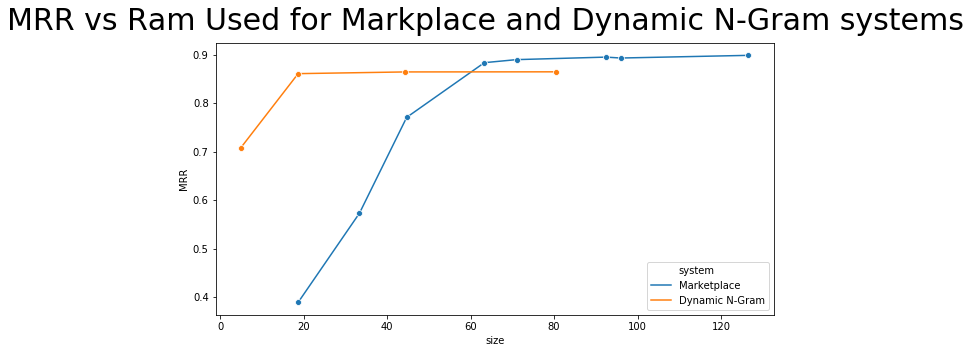

In [556]:
fig, axes = plt.subplots(figsize = (10,5))

sns.lineplot(ax = axes, data = ramData, x = 'size', y = 'MRR', hue = 'system', marker = 'o')

# Analysis Plot 4: Database Coverages

In [217]:
sortedNotCoveredHasBscore = [0,
 175,
 288,
 306,
 331,
 742,
 1069,
 1139,
 1234,
 1298,
 1515,
 1573,
 1659,
 1765,
 1772,
 1798,
 1875,
 1989,
 1995,
 2054,
 2607,
 2621,
 2756,
 2811,
 2833,
 2940,
 3201,
 3473,
 3622,
 4055,
 4241,
 4261,
 4705,
 4739,
 4769,
 4820,
 5097,
 5348,
 5941,
 5996,
 6018,
 6046,
 6327,
 6499,
 6552,
 6556,
 7011,
 7372,
 7387,
 7512,
 7721,
 8008,
 8346,
 8358,
 8431,
 8455,
 8670,
 8943,
 9258,
 9376,
 9606,
 9991,
 10010,
 10035,
 10149,
 10361,
 10460,
 10628,
 10911,
 10976,
 11376,
 11399,
 11619,
 11620,
 11622,
 11910,
 11935,
 12099,
 12345,
 12509,
 12570,
 12604,
 12618,
 12925,
 13007,
 13072,
 13161,
 13192,
 13397,
 13480,
 13530,
 13596,
 13987,
 14205,
 14315,
 14554,
 14862,
 14863,
 14881,
 14965,
 15233,
 15284,
 15434,
 15540,
 15608,
 15781,
 16338,
 16545,
 16638,
 16992,
 17083,
 17098,
 17117,
 17162,
 17488,
 17554,
 17593,
 17747,
 17754,
 17764,
 17959,
 18008,
 18122,
 18187,
 18309,
 18317,
 18467,
 18530,
 18733,
 19146,
 19347,
 19352,
 19524,
 19838,
 19853,
 20498,
 20574,
 20666,
 20870,
 21022,
 21390,
 21516,
 21916,
 21975,
 22224,
 22289,
 22522,
 22615,
 22978,
 23076,
 23131,
 23245,
 23527,
 23663,
 24190,
 24229,
 24430,
 24436,
 24635,
 24896,
 24936,
 25103,
 25129,
 25441,
 25498,
 25881,
 26000,
 26141,
 26384,
 26397,
 26425,
 26538,
 26874,
 27209,
 27249,
 27490,
 27542,
 27570,
 27579,
 27644,
 27698,
 27839,
 27876,
 28032,
 28101,
 28165,
 28499,
 28539,
 28916,
 29065,
 29380,
 29671,
 29884,
 29891,
 30215,
 30233,
 30359,
 30377,
 30522,
 30898,
 30907,
 31031,
 31673]

In [223]:
np.sum(np.abs(bscore))

1406.0

In [225]:
np.sum(np.abs(bscore[61]))

1406.0

In [226]:
toCheck = []

for i,pieceNum in enumerate(sortedNotCoveredHasBscore):
    print(i)
    fname = f'/mnt/data0/agoutam/bootleg_total/{num_to_piece[288]}.pkl'
    bscore = getTotalBscore(fname) #Compute bootleg score
    if(np.sum(np.abs(bscore)) != np.sum(np.abs(bscore[61]))):
        print("MIGHT BE A VALID BSCORE", pieceNum)O
        toCheck.append(pieceNum)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


In [6]:
from ExtractBootlegFeatures import *

ModuleNotFoundError: No module named 'ExtractBootlegFeatures'

In [227]:
visualizeLongBootlegScore(bscore_query, [13,15,17,19,21,35,37,39,41,43])

[]

0


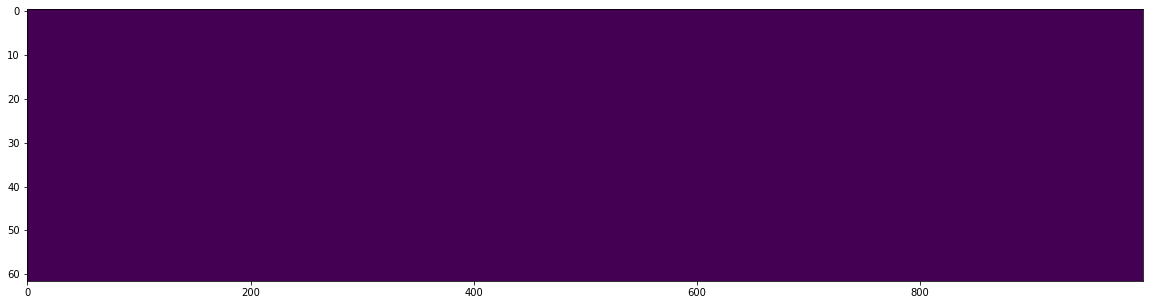

1000


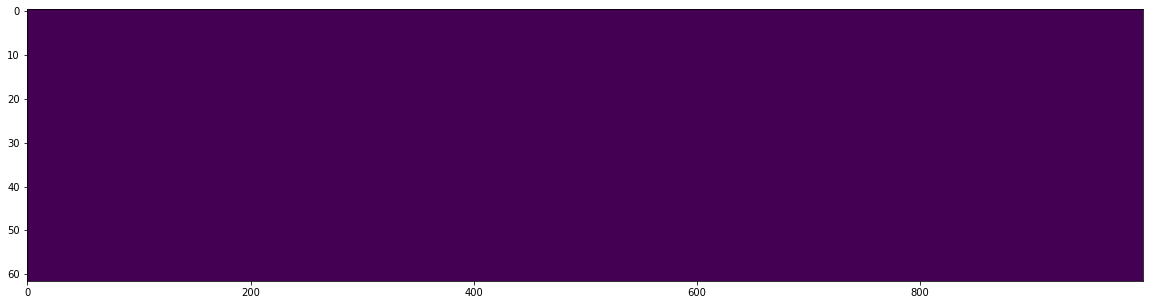

2000


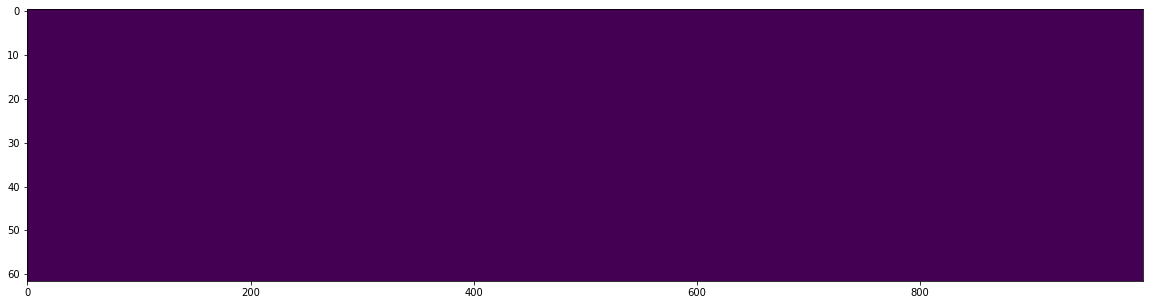

3000


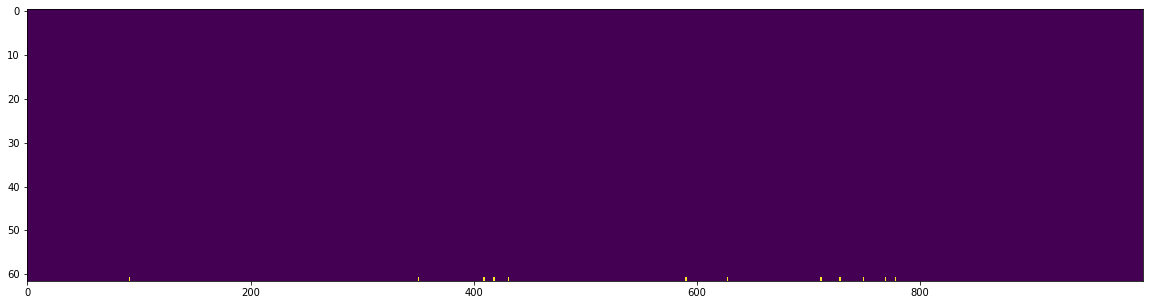

4000


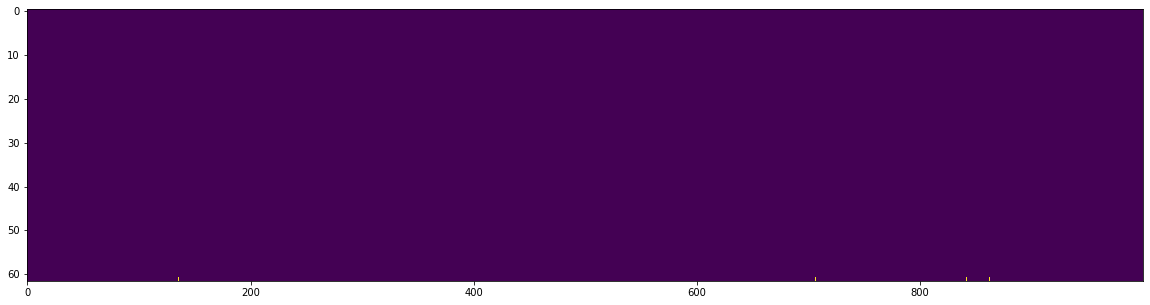

5000


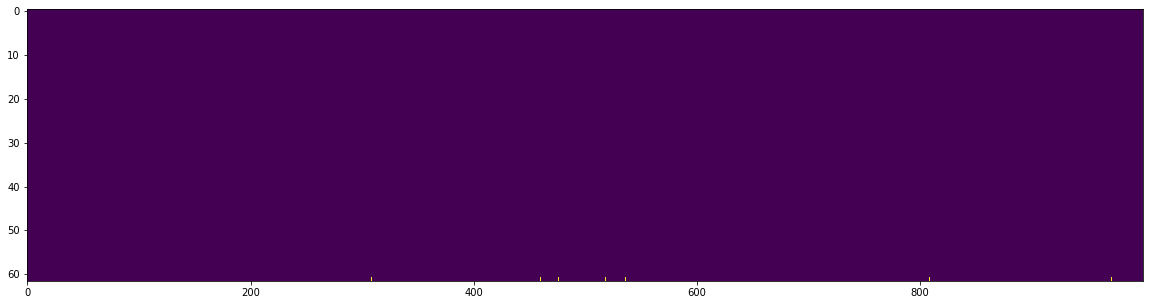

6000


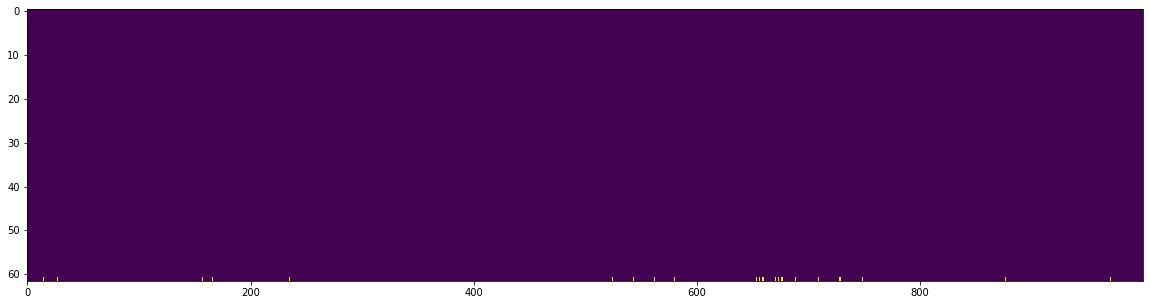

7000


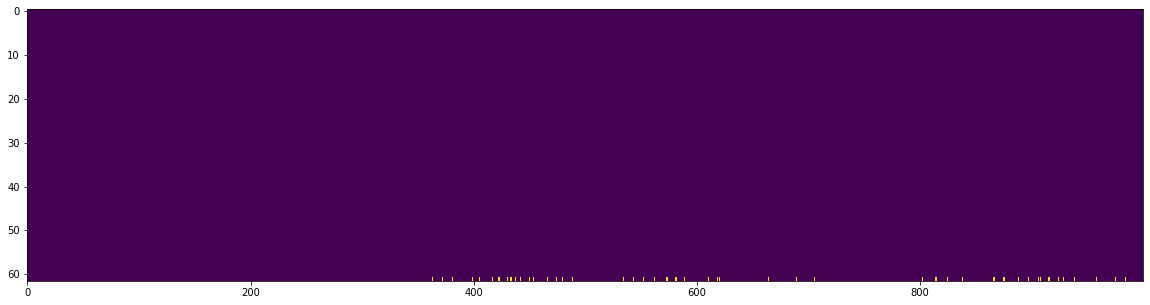

8000


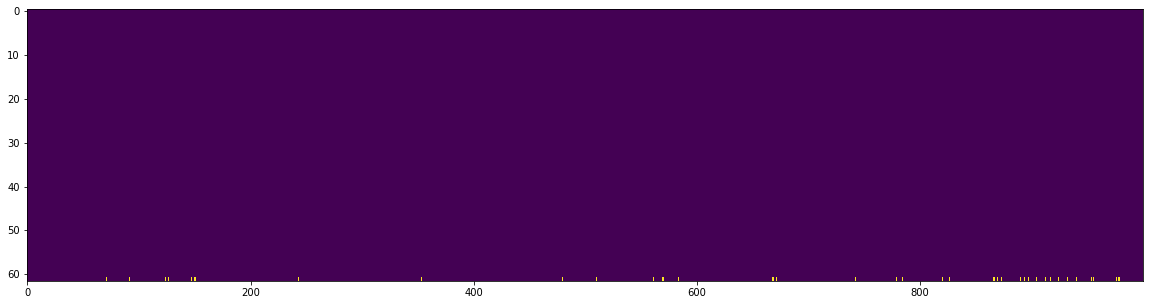

9000


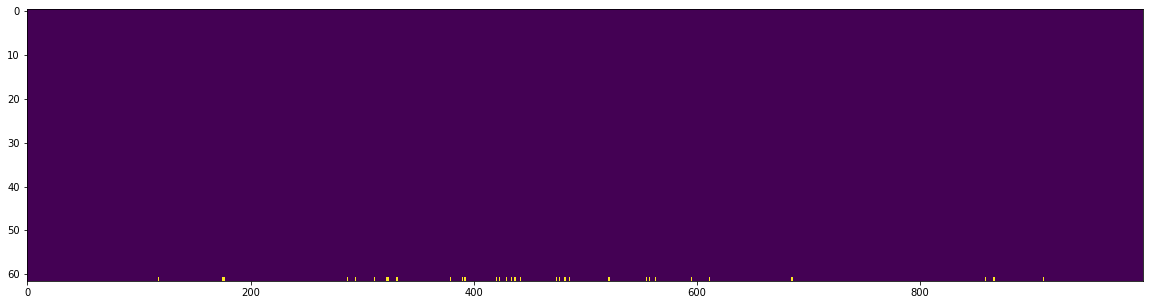

10000


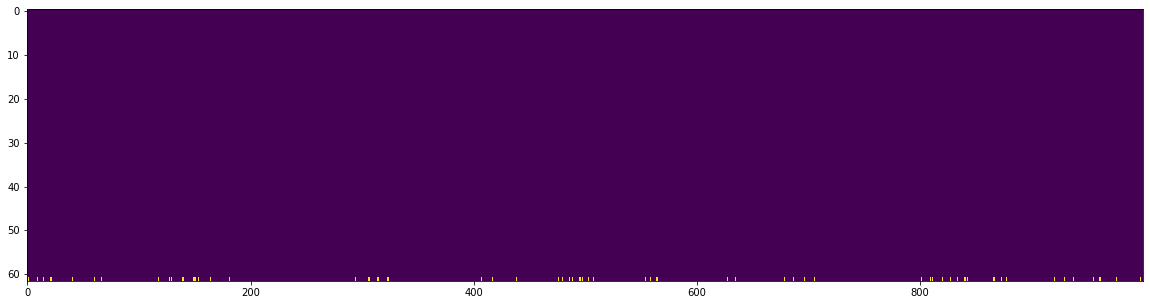

11000


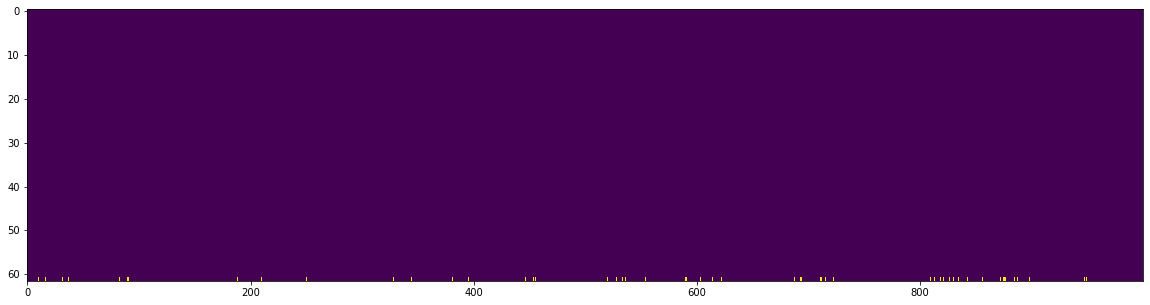

12000


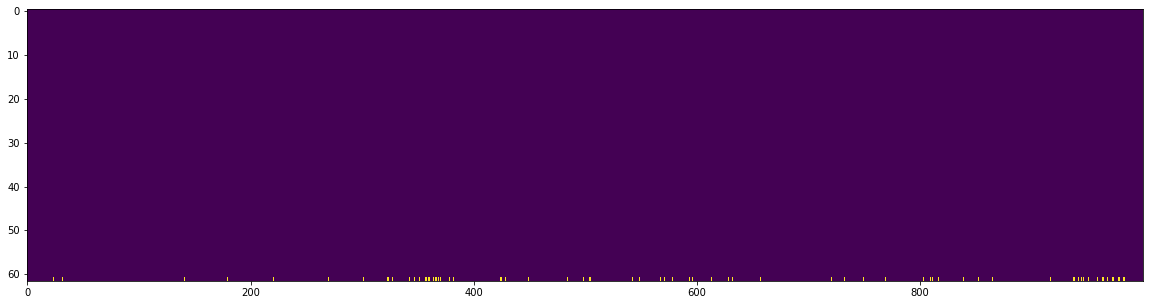

13000


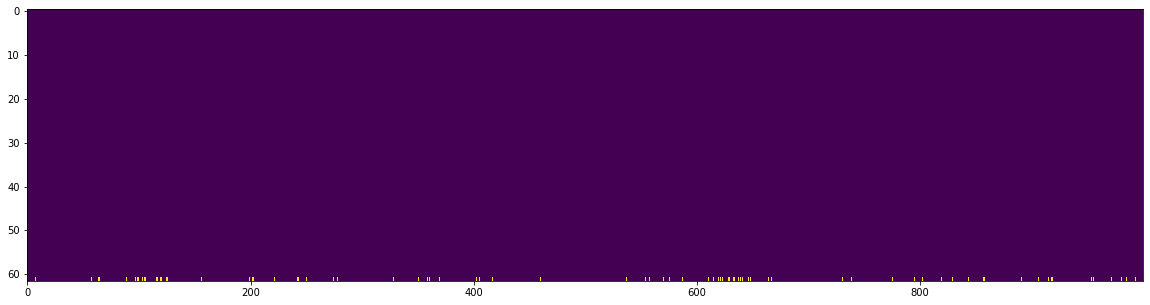

14000


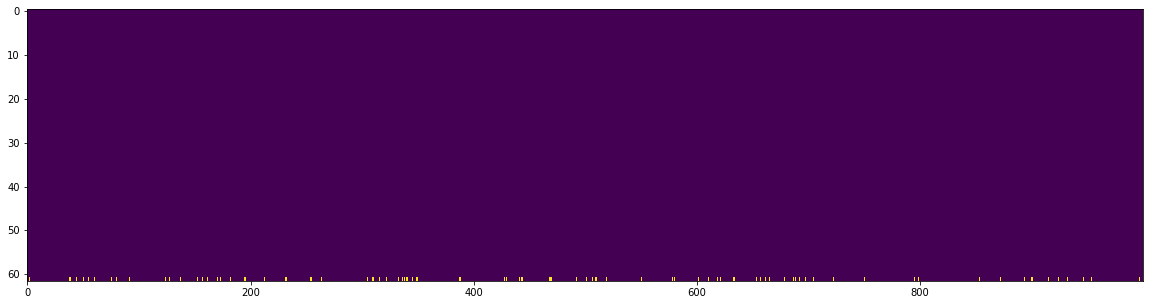

15000


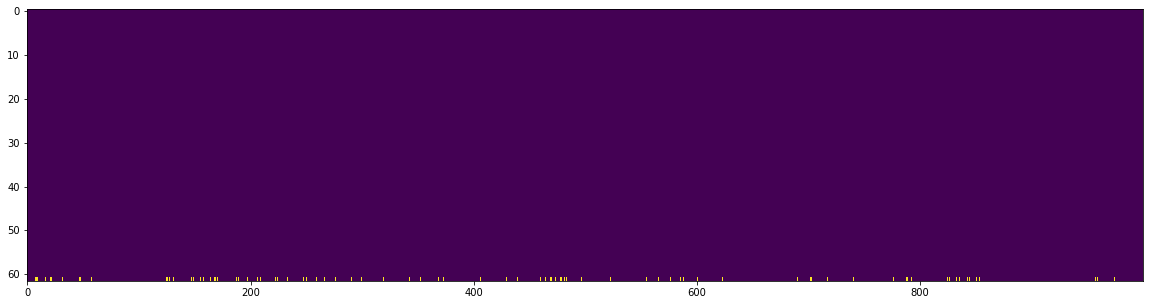

16000


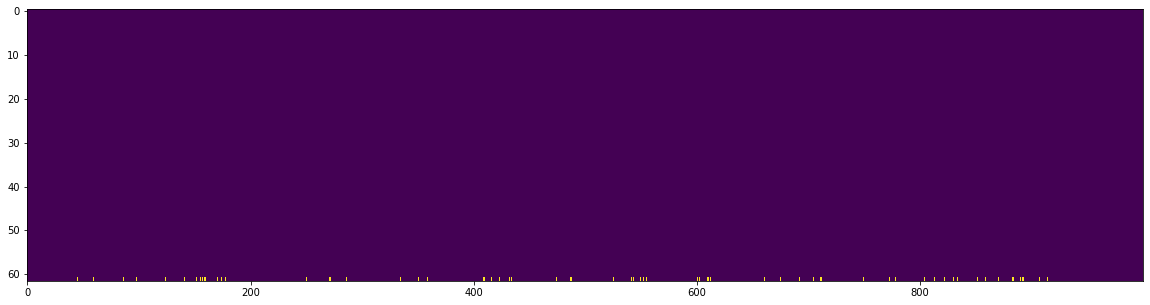

17000


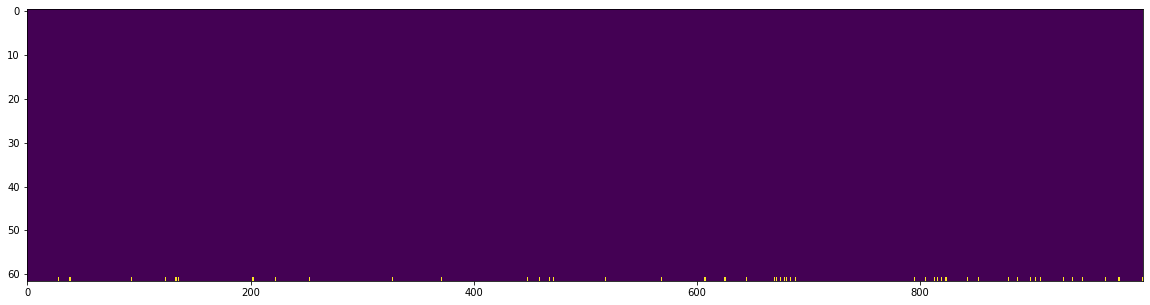

18000


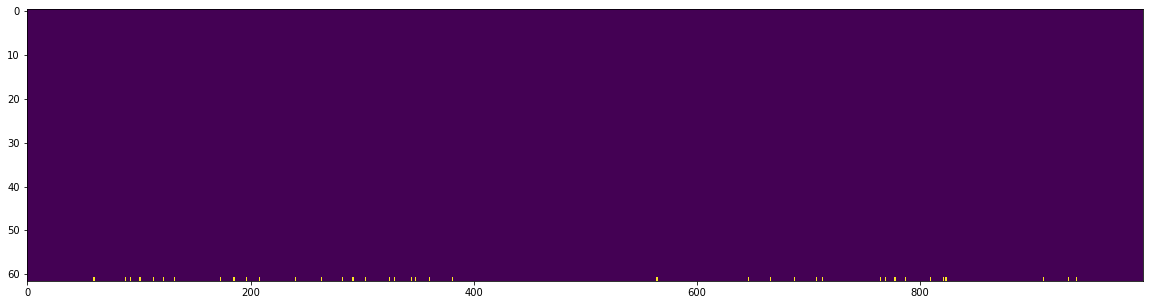

19000


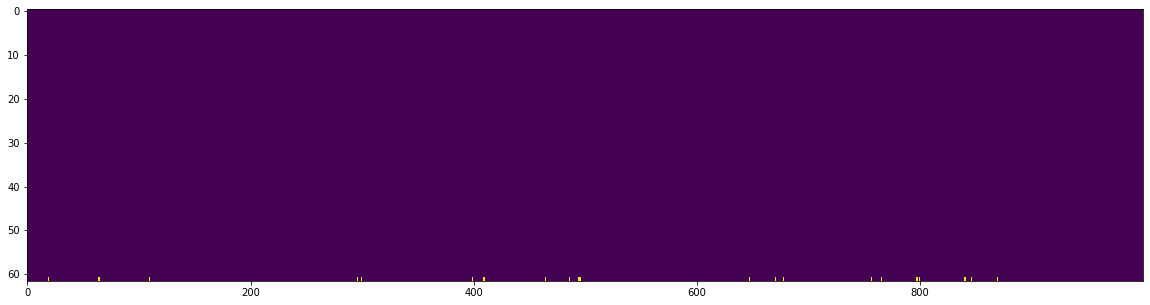

20000


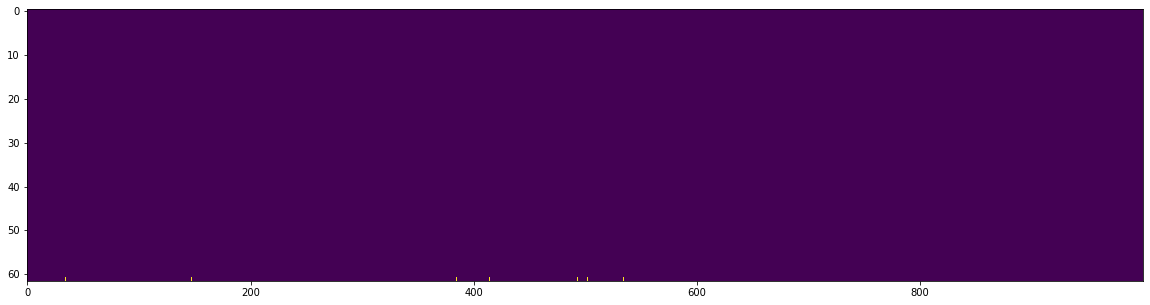

21000


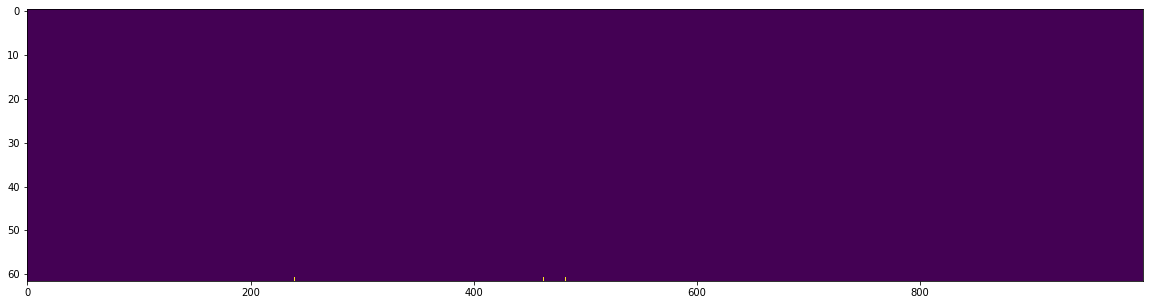

22000


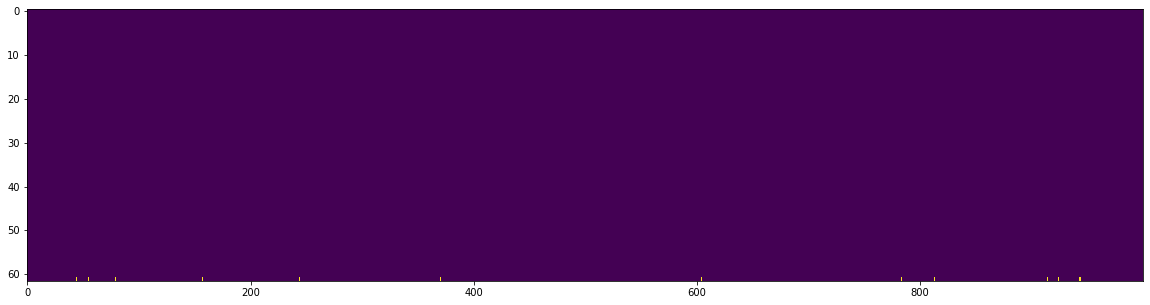

23000


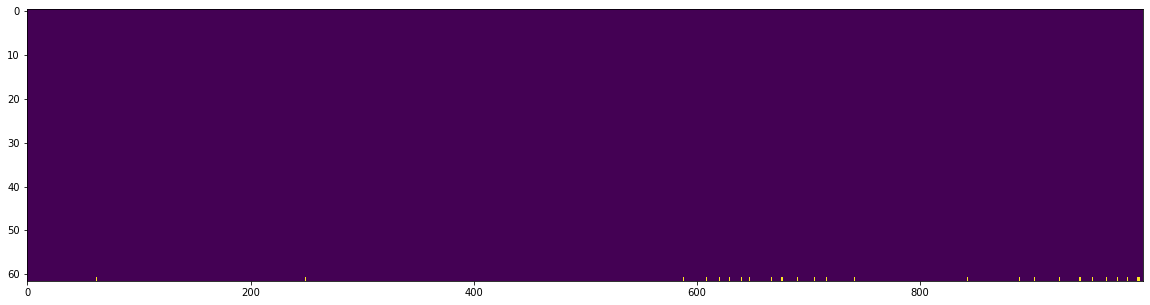

24000


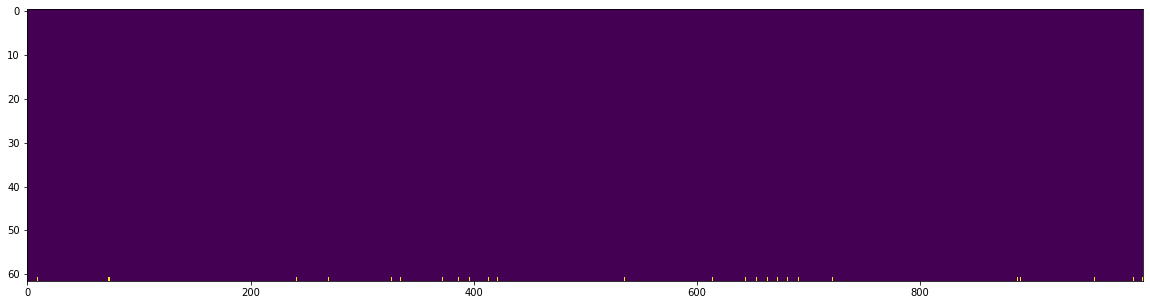

25000


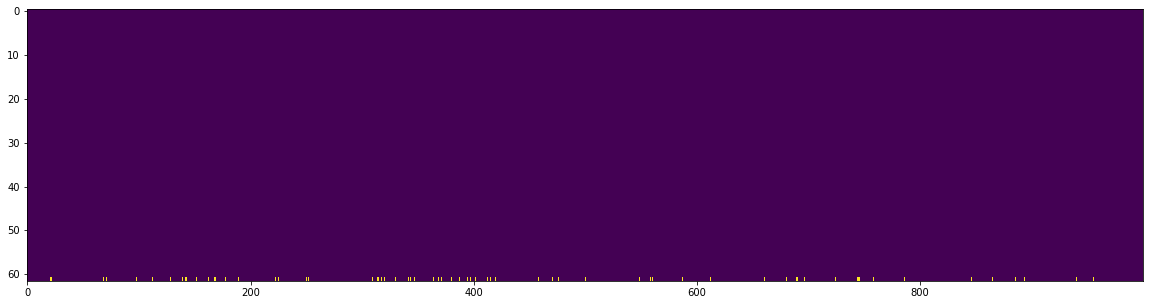

26000


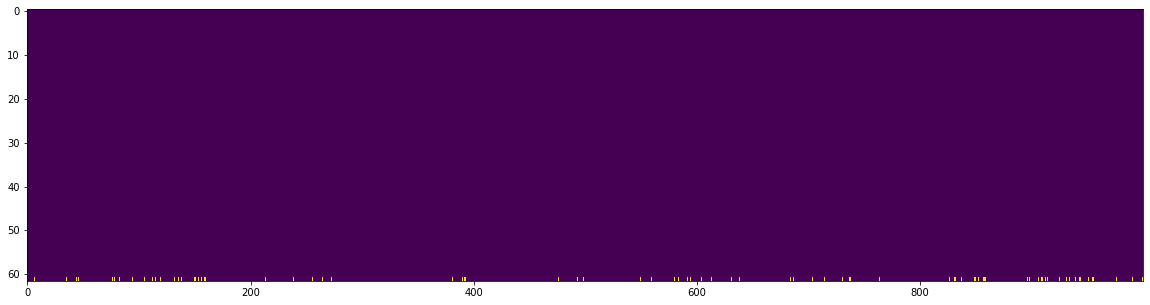

27000


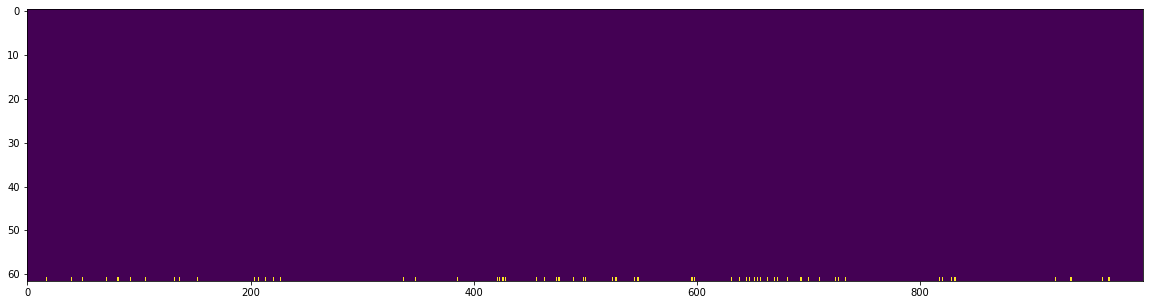

28000


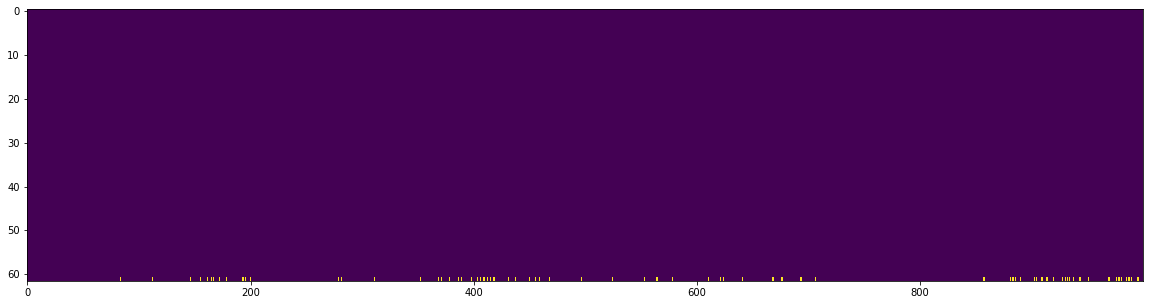

29000


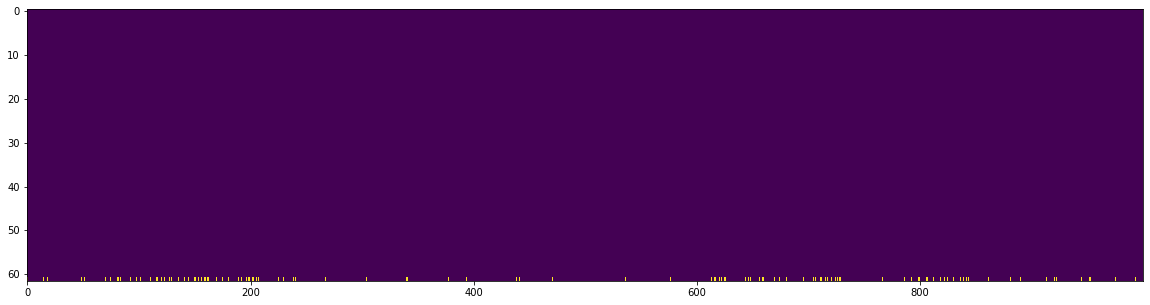

30000


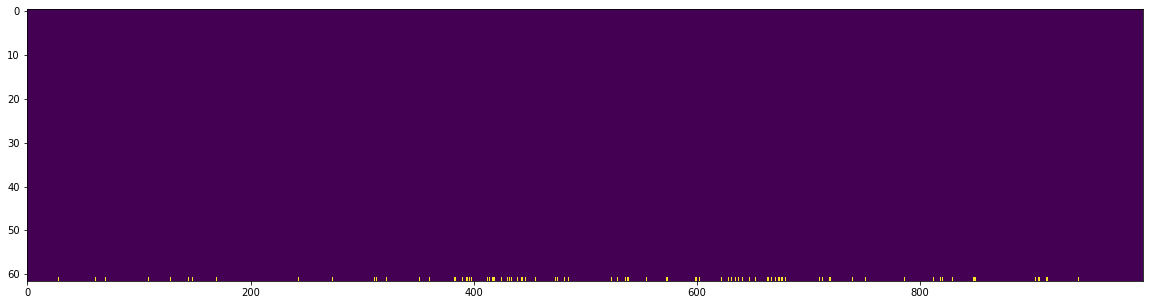

31000


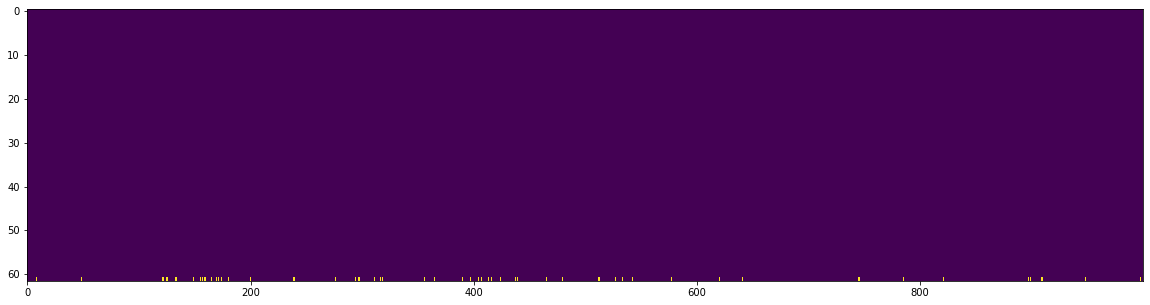

32000


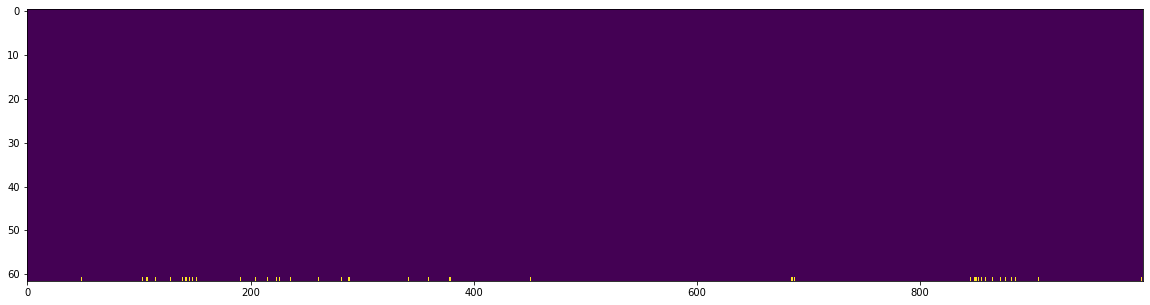

33000


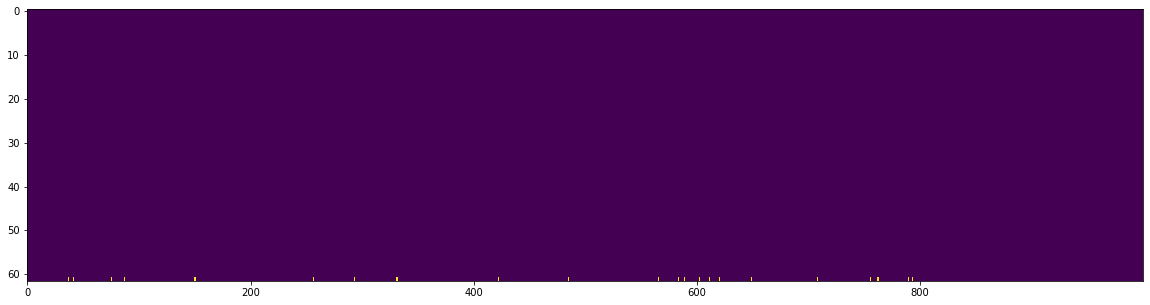

34000


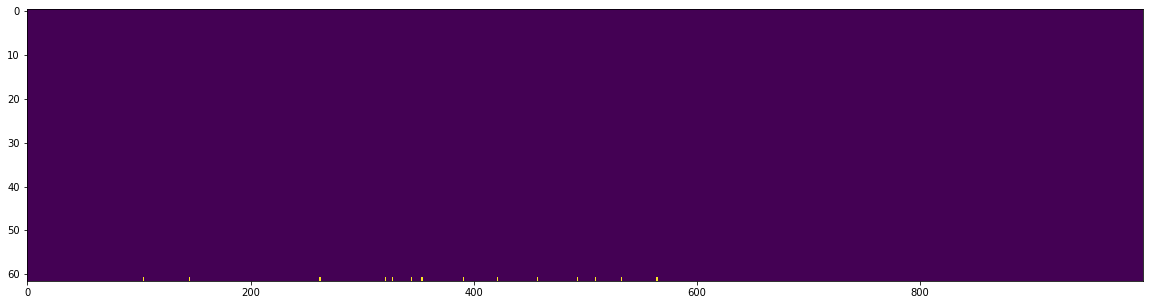

35000


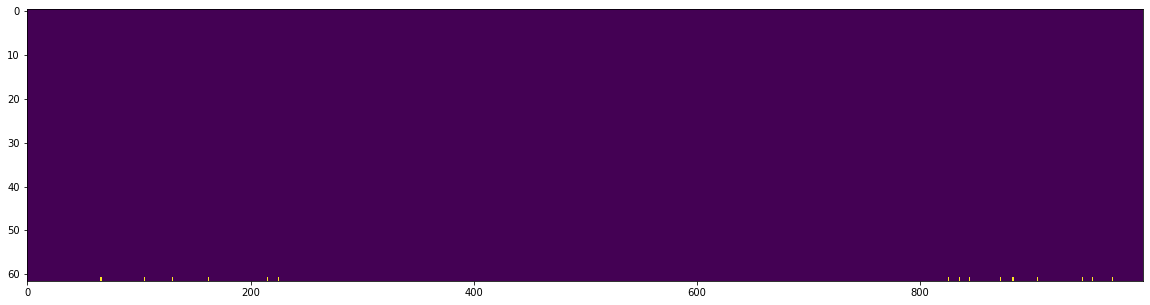

36000


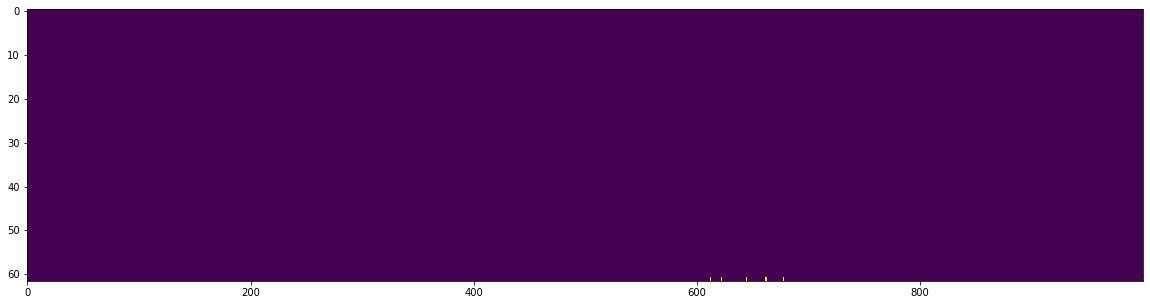

37000


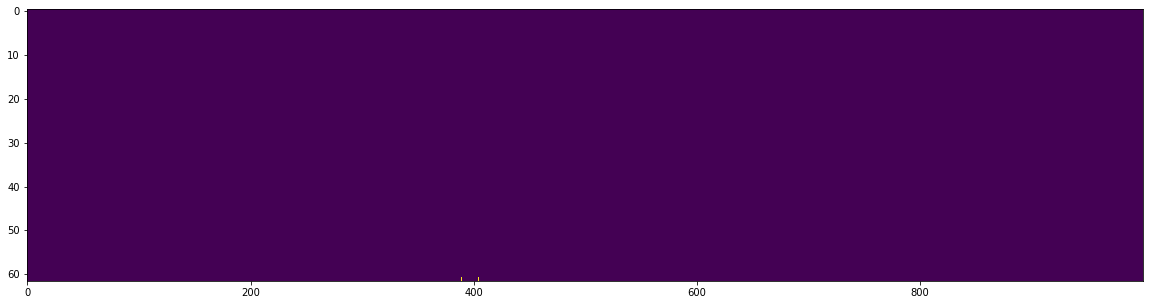

38000


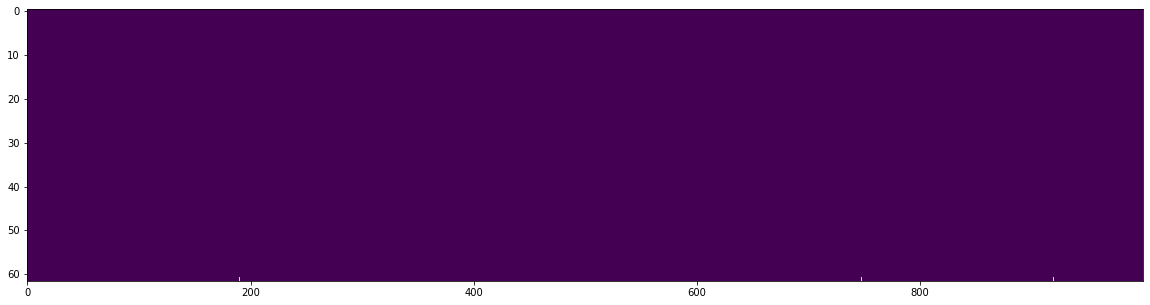

39000


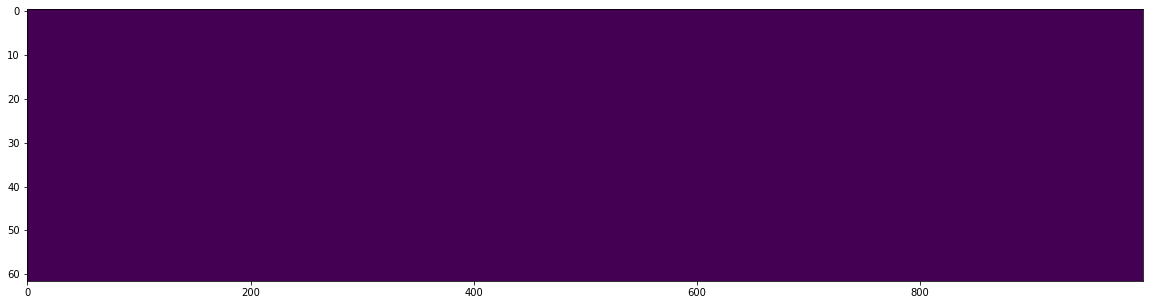

40000


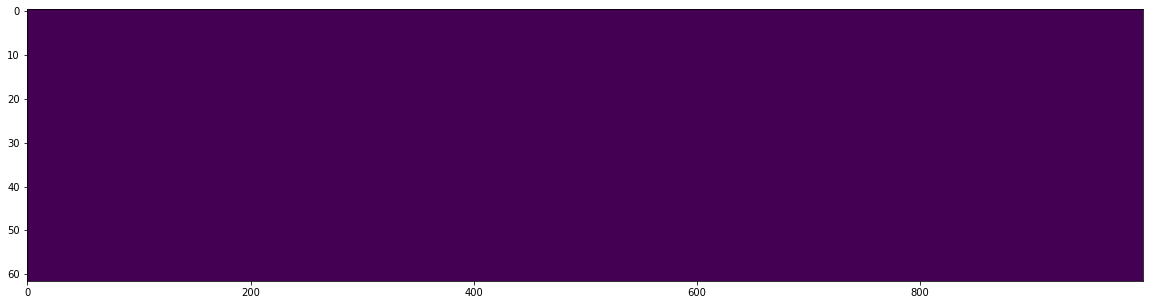

41000


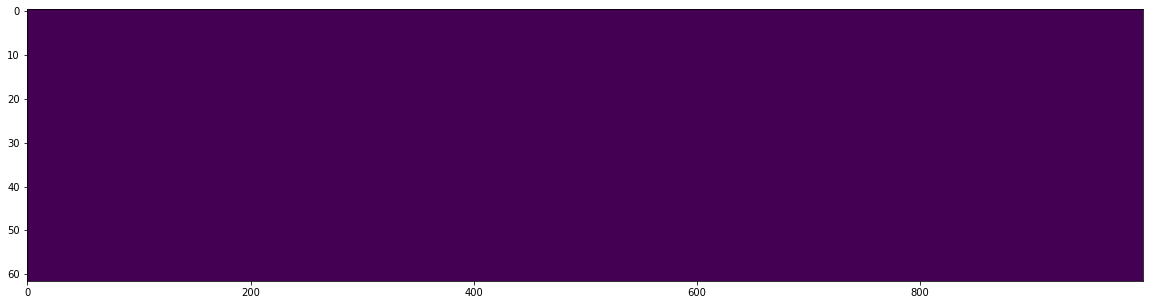

42000


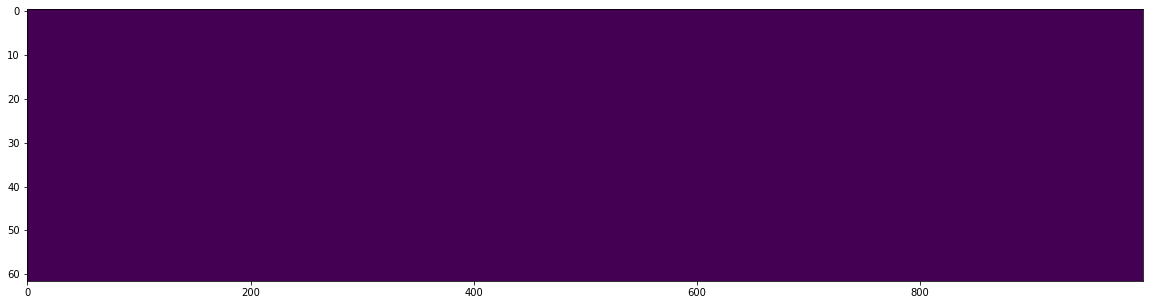

43000


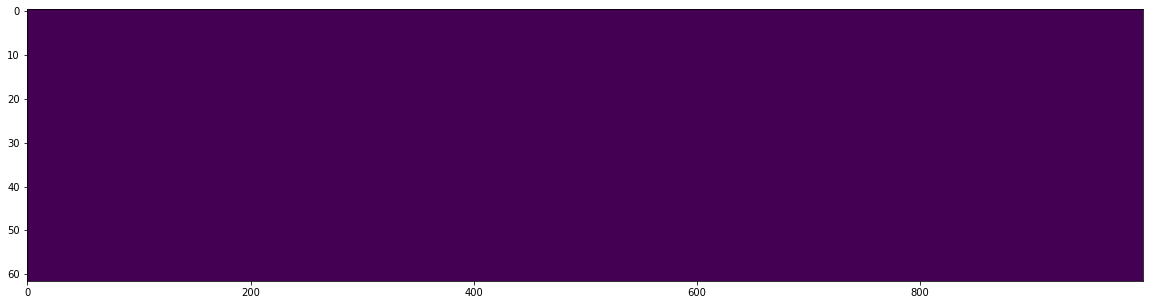

44000


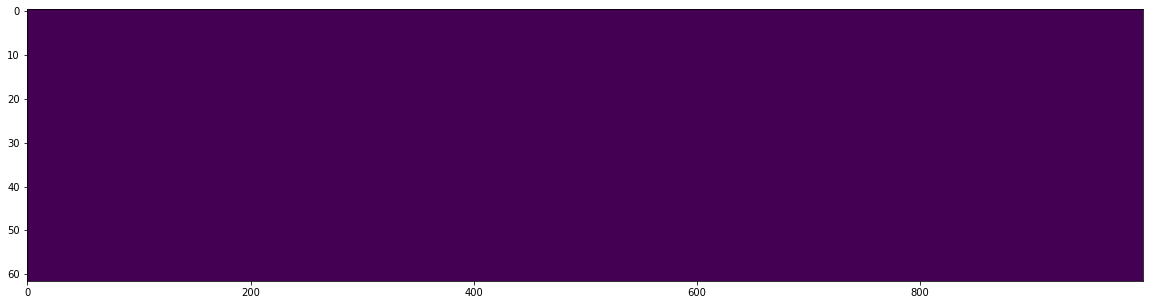

45000


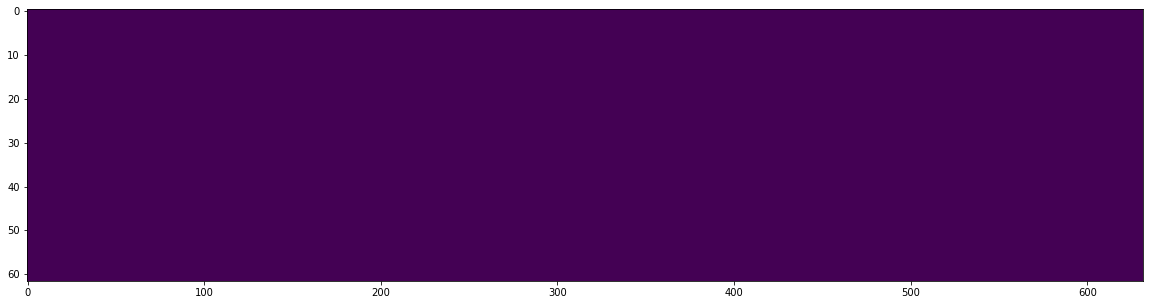

In [216]:
for i in range(np.round(bscore.shape[1]/1000).astype(int)):
    print(i*1000)
    plt.figure(figsize = (20,5))
    plt.imshow(bscore[:,i*1000:(i+1)*1000], aspect = 'auto')
    plt.show()

In [167]:
powers = 1 << np.arange(62)[::-1]

In [168]:
combinations = []
for n_gram in range(1, 4):
    combinations += [[0] + list(tup) for tup in itertools.combinations(range(1, 6), n_gram-1)]

In [169]:
def getTotalBscore(bscore_file):
    bscore_array = []
    with open(bscore_file,'rb') as f:
        bscore_array = pickle.load(f)
    total_bscore = np.array([]).reshape(62,0)
    for page in bscore_array:
        try:
            total_page = unpackbits(np.array(page), 62)
        except TypeError:
            total_page = np.array([]).reshape(62,0)
            for num in page:
                col = np.array(decodeColumn(num)).reshape(62,-1)
                total_page = np.concatenate((total_page,col),axis=1)
        total_bscore = np.concatenate((total_bscore,total_page),axis=1)
    return total_bscore

def decodeColumn(num):
    col = []
    for i in range(62):
        col.insert(0,num%2)
        num = int(num/2)
    return col

def unpackbits(x, num_bits):
    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])
    return np.flip((x & mask).astype(bool).astype(float), 1).T

def make_fps(data, combinations, dbs, piece):
    for colindex in range(len(data)):
        for combination in combinations:
            cols = []
            # we need at least enough fingerprints for all the indices in our combination
            try:
                for i in combination:
                    cols.append(data[colindex+int(i)])
            except IndexError:
                continue
            fp = []
            equals_Zero = True
            for column in cols:
                hashint = int(column.dot(powers))
                fp.append(hashint)
                if hashint != 0:
                    equals_Zero = False
            if equals_Zero == True:
                continue
            dbs[combination][tuple(fp)][piece].append(colindex)
            
def compute_fingerprint(cols):
    fp = []
    equals_Zero = True
    for column in cols:
        hashint = int(column.dot(powers))
        fp.append(hashint)
        if hashint != 0:
            equals_Zero = False
    if equals_Zero == True:
        return None
    return tuple(fp)

In [170]:
def getSingleNGramCoverage(nGramD, comb, pieceNum, withContext = False):
    fname = f'/mnt/data0/agoutam/bootleg_total/{num_to_piece[pieceNum]}.pkl'
    bscore = getTotalBscore(fname) #Compute bootleg score
    if(bscore[0].shape[0] == 0):
        return None
    numCols = bscore.shape[1] 
    covered = np.zeros(numCols) # covered array

    for col in range(numCols):# Every possible offset
        colsToHash = np.zeros((62,len(comb)))
        if(col + int(comb[-1]) >= numCols):
            continue
        for i, nGramOffset in enumerate(comb):
            colsToHash[:,i] = bscore[:, col + int(nGramOffset)]
        colNGramFps = compute_fingerprint(colsToHash.T) # Specific n gram for specific offset
        if(colNGramFps in nGramD.keys()):
            if withContext:
                for i, nGramOffset in enumerate(comb):
                    covered[col + int(nGramOffset)] = 1
            else:
                covered[col] = 1
    return covered

In [171]:
def getBothSingleNGramCoverage(nGramDKeySet, comb, pieceNum):
    fname = f'/mnt/data0/agoutam/bootleg_total/{num_to_piece[pieceNum]}.pkl'
    bscore = getTotalBscore(fname) #Compute bootleg score
    if(bscore[0].shape[0] == 0):
        #print('BSCORE DOESNT EXIST', pieceNum, bscore.shape)
        return (None, None)
    numCols = bscore.shape[1] 
    coveredRaw = np.zeros(numCols) # covered array
    coveredContext = np.zeros_like(coveredRaw)

    for col in range(numCols):# Every possible offset
        colsToHash = np.zeros((62,len(comb)))
        if(col + int(comb[-1]) >= numCols):
            continue
        for i, nGramOffset in enumerate(comb):
            colsToHash[:,i] = bscore[:, col + int(nGramOffset)]
        colNGramFps = compute_fingerprint(colsToHash.T) # Specific n gram for specific offset
        if(colNGramFps in nGramDKeySet):
            for i, nGramOffset in enumerate(comb):
                coveredContext[col + int(nGramOffset)] = 1
            coveredRaw[col] = 1
    return coveredRaw, coveredContext



In [172]:
def computeCoverages(db_dir):
    allCoveredRaw = np.zeros(numPieces, dtype = object)
    allCoveredContext = np.zeros(numPieces, dtype = object)

    dbFiles = list(glob.iglob(f"{db_dir}/0*.pkl", recursive=True))
    dbFiles.sort()
    for filename in dbFiles:
        #print(filename)
        comb = filename.split('/')[-1][:-4]

        with open(filename, "rb") as f:
            nGramD = pickle5.load(f) #sometimes dill
        
        nGramDKeySet = set(nGramD.keys())
        print('numKeys in',filename,len(nGramDKeySet))
        
        print('loaded', comb)
        prevTime = time.time()
        for pieceNum in range(numPieces):#TODO: change this to numPieces
            if(pieceNum %1000 == 0):
                curTime = time.time()
                print('time for 1000 pieces for', filename.split('/')[-1], curTime-prevTime)
                prevTime = curTime
                print(pieceNum)
            coveredRaw, coveredContext = getBothSingleNGramCoverage(nGramDKeySet, comb, pieceNum)
            if coveredRaw is not None:
                if(allCoveredRaw[pieceNum] is 0):
                    allCoveredRaw[pieceNum] = coveredRaw.astype(bool)
                else:
                    allCoveredRaw[pieceNum] = allCoveredRaw[pieceNum] | coveredRaw.astype(bool)
            if coveredContext is not None:
                if(allCoveredContext[pieceNum] is 0):
                    allCoveredContext[pieceNum] = coveredContext.astype(bool)
                else:
                    allCoveredContext[pieceNum] = allCoveredContext[pieceNum] | coveredContext.astype(bool)

        del nGramD
        print('finished', comb)
        
    return allCoveredRaw, allCoveredContext 

In [173]:
def computeCoveragesDynamic(gamma):
    allCoveredRaw = np.zeros(numPieces, dtype = object)
    allCoveredContext = np.zeros(numPieces, dtype = object)

    combs = ['0','01','012','0123']
    
    Max_N = 2
    
    for i in range(1, Max_N+1):
        print("LOADING {}".format(i))
        pickle_file = '/mnt/data0/agoutam/newDynamicNGram/indices/N_GRAM_{}_ALL.pkl'.format(i)
        count_file = '/mnt/data0/agoutam/newDynamicNGram/indices/N_GRAM_{}_COUNT.pkl'.format(i)
        with open(pickle_file, 'rb') as f:
            nGramD = pickle.load(f)
            f.flush()
            f.close()
        with open(count_file, 'rb') as f:
            nGramCounts = pickle.load(f)
            f.flush()
            f.close()

        comb = combs[i-1]
        
        nGramKeyList = list(nGramD.keys())

        for i,key in enumerate(nGramKeyList):
            if(nGramCounts[key] > gamma):
                del nGramD[key]
        
        nGramDKeySet = set(nGramD.keys())
        print('numKeys in', pickle_file ,len(nGramDKeySet))
        
        print('loaded', comb)
        for pieceNum in range(numPieces):
            if(pieceNum % 1000 == 0):
                print(pieceNum)
            coveredRaw, coveredContext = getBothSingleNGramCoverage(nGramDKeySet, comb, pieceNum)
            if coveredRaw is not None:
                if(allCoveredRaw[pieceNum] is 0):
                    allCoveredRaw[pieceNum] = coveredRaw.astype(bool)
                else:
                    allCoveredRaw[pieceNum] = allCoveredRaw[pieceNum] | coveredRaw.astype(bool)
            if coveredContext is not None:
                if(allCoveredContext[pieceNum] is 0):
                    allCoveredContext[pieceNum] = coveredContext.astype(bool)
                else:
                    allCoveredContext[pieceNum] = allCoveredContext[pieceNum] | coveredContext.astype(bool)

        del nGramD
        print('finished', comb)
        
    return allCoveredRaw, allCoveredContext 

In [139]:
# db_dir = "/mnt/data0/agoutam/databases_v4_pdfs/103mil"
# allCoveredRaw, allCoveredContext = computeCoverages(db_dir)

In [140]:
# allCoveredRaw, allCoveredContext = computeCoveragesDynamic(10000)

In [123]:
# actualCoveragesContext = np.zeros_like(allCoveredContext)

# for i,covered in enumerate(allCoveredContext):
#     if covered is 0:
#         actualCoveragesContext[i] = 0
#     else:
#         actualCoveragesContext[i] = np.sum(covered)/covered.shape[0]

In [124]:
# actualCoveragesRaw = np.zeros_like(allCoveredRaw)

# for i,covered in enumerate(allCoveredRaw):
#     if covered is 0:
#         actualCoveragesRaw[i] = 0
#     else:
#         actualCoveragesRaw[i] = np.sum(covered)/covered.shape[0]

In [ ]:
# dataToDump = (allCoveredRaw, allCoveredContext)

In [ ]:
# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Dyn10kPlot4Covered.pkl', 'wb') as plotFile:
#     pickle.dump(dataToDump,plotFile)

In [117]:
# actualCoveragesContext = actualCoveragesContext
# coveragesDataContext = pd.DataFrame({'system': 'Dynamic 10k with context', 'pdfNum': np.arange(len(actualCoveragesContext)) + 1, "coverage": np.sort(np.array(actualCoveragesContext))[::-1]})

In [118]:
# actualCoveragesRaw = actualCoveragesRaw
# coveragesDataRaw = pd.DataFrame({'system': 'Dynamic 10k no context', 'pdfNum': np.arange(len(actualCoveragesRaw)) + 1, "coverage": np.sort(np.array(actualCoveragesRaw))[::-1]})

In [119]:
# newCoveragesData = coveragesDataContext.append(coveragesDataRaw)

In [141]:
# with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Marketplace128.pkl', 'wb') as plotFile:
#     pickle.dump(coveragesData,plotFile)

In [18]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Marketplace128.pkl', 'rb') as plotFile:
    coveragesDataMP128 = pickle.load(plotFile)

In [19]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Marketplace96.pkl', 'rb') as plotFile:
    coveragesDataMP96 = pickle.load(plotFile)

In [20]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Marketplace64.pkl', 'rb') as plotFile:
    coveragesDataMP64 = pickle.load(plotFile)

In [21]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Marketplace32.pkl', 'rb') as plotFile:
    coveragesDataMP32 = pickle.load(plotFile)

In [22]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Dynamic1k.pkl', 'rb') as plotFile:
    coveragesDataDyn1k = pickle.load(plotFile)

In [23]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Dynamic10k.pkl', 'rb') as plotFile:
    coveragesDataDyn10k = pickle.load(plotFile)

In [52]:
coveragesData = coveragesDataMP128.append((coveragesDataMP64,coveragesDataMP32,coveragesDataDyn1k,coveragesDataDyn10k))

In [53]:
piece_mapping_dir = "/home/agoutam/ImprovedSheetID/num_to_piece.pkl"
with open(piece_mapping_dir, 'rb') as f:
    num_to_piece = pickle5.load(f)
numNoBscores = 2678
numPieces = len(num_to_piece.keys())

In [54]:
coveragesData = coveragesData[(coveragesData['pdfNum'] < numPieces - numNoBscores - 203)]
maxPDFNum = np.max(coveragesData['pdfNum'].values)
coveragesData = coveragesData[coveragesData['system'].str.contains('no')]
coveragesData['system'] = coveragesData['system'].str[0:-11]
coveragesData['pdfNum'] = numPieces - numNoBscores - 203- coveragesData['pdfNum'] 
coveragesData['coverage'] = coveragesData['coverage'] * 100

In [55]:
coveragesData

,system,pdfNum,coverage
0,128 GB Marketplace,29152,100
1,128 GB Marketplace,29151,100
2,128 GB Marketplace,29150,100
3,128 GB Marketplace,29149,100
4,128 GB Marketplace,29148,100
...,...,...,...
29147,Dynamic 10k,5,45.8333
29148,Dynamic 10k,4,45.8333
29149,Dynamic 10k,3,45.8333
29150,Dynamic 10k,2,45.8333


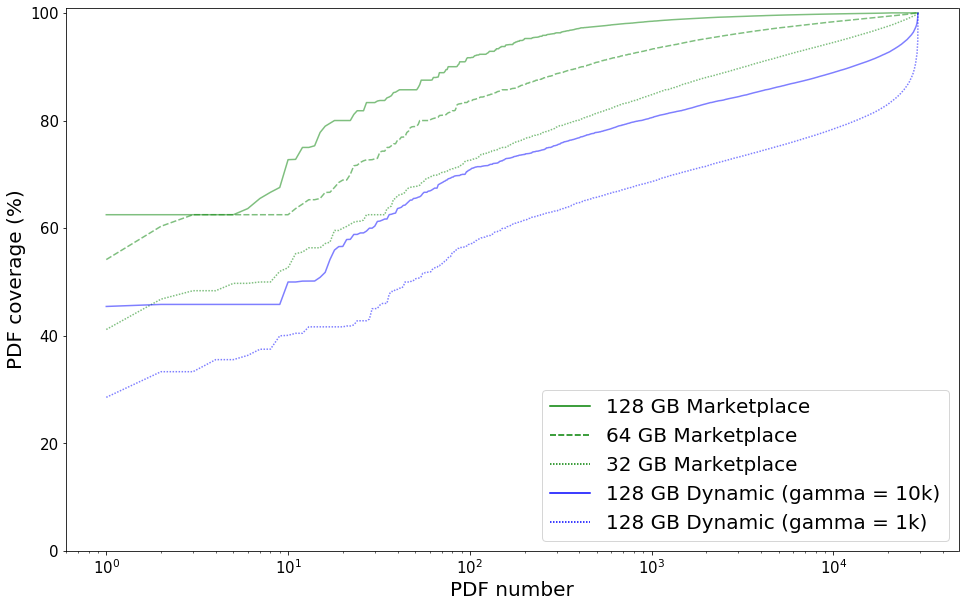

In [58]:
fig, ax = plt.subplots(1,1,figsize = (FIG_X_SIZE,FIG_Y_SIZE))

#coveragesData = coveragesData[(coveragesData['pdfNum'] > 29100) & (coveragesData['pdfNum'] < 29400)]


# sns.lineplot(ax = ax[0], x="pdfNum", y="coverage",
#             style="system", hue="system", estimator=None, data = coveragesData[coveragesData['system'].str.contains('with')],
#             alpha = 0.5, palette = ['green'] * 4 + ['blue'] * 2);

# ax[0].set_xlabel('', fontsize = 40)
# #ax[0].set_xticklabels(np.arange(7)*5000,size = 15)
# #ax[0].set_xlim(0,numPieces - numNoBscores + 500)

# ax[0].set_ylabel('% pdf coverage', fontsize = 40)
# ax[0].set_yticklabels([0]+list(np.round(np.linspace(0,1,6),1)),size = 15)
# ax[0].set(xscale="log")

MPCoverageData = coveragesData[coveragesData['system'].str.contains('Mark')]
DNCoverageData = coveragesData[coveragesData['system'].str.contains('Dyn')]

DNCoverageData = DNCoverageData[DNCoverageData['system'] == 'Dynamic 10k'].append(DNCoverageData[DNCoverageData['system'] == 'Dynamic 1k']) 

sns.lineplot(ax = ax, x="pdfNum", y="coverage",
            style="system", hue="system", estimator=None, data = MPCoverageData, 
            alpha = 0.5, palette = ['green'] * 3);

sns.lineplot(ax = ax, x="pdfNum", y="coverage",
            style="system", hue="system", estimator=None, data = DNCoverageData, 
            alpha = 0.5, palette = ['blue'] * 2, dashes = {'Dynamic 10k':'','Dynamic 1k': (1,1)});

handles, labels = ax.get_legend_handles_labels()

labels = ['128 GB Marketplace', '64 GB Marketplace', '32 GB Marketplace', '128 GB Dynamic (gamma = 10k)', '128 GB Dynamic (gamma = 1k)']

ax.legend(handles=handles[1:4]+handles[5:], labels=labels, fontsize = LEGEND_LABEL_SIZE)

ax.set(xscale="log")
ax.set_xlabel('PDF number', fontsize = AXIS_LABEL_SIZE)
#ax.set_xticks(np.array([0,100,1000,10000])+10**logShift)
#ax.set_xticklabels([0,100,1000,10000], size = TICK_LABEL_SIZE)



ax.set_ylabel('PDF coverage (%)', fontsize = AXIS_LABEL_SIZE)
ax.set_ylim(0,101)
#ax.set_yticklabels([0]+list(np.round(np.linspace(0,1,6),1)),size = TICK_LABEL_SIZE)

plt.xticks(fontsize = TICK_LABEL_SIZE)
plt.yticks(fontsize = TICK_LABEL_SIZE)

#plt.legend(['Marketplace 128 Context', 'Marketplace 128'])

plt.show()

/home/agoutam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/agoutam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


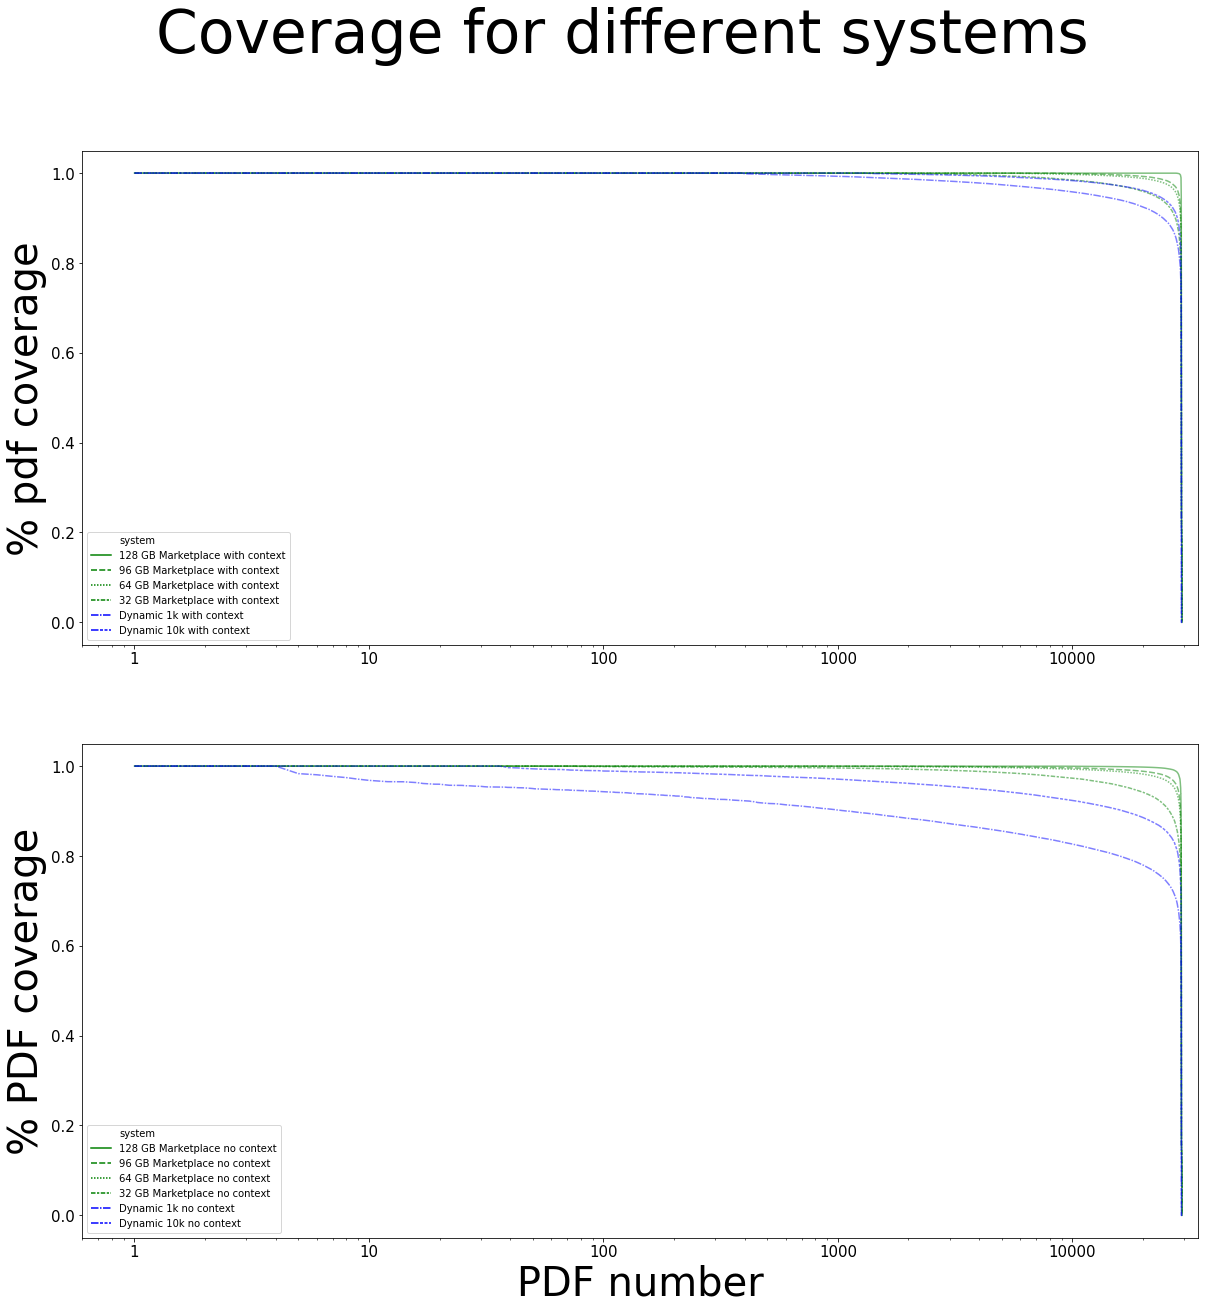

In [162]:
# truncCoveragesDataMP128 = coveragesDataMP128[coveragesDataMP128['coverage'] == 0]
# truncCoveragesDataMP128[truncCoveragesDataMP128['system'].str.contains('with')]
# truncCoveragesData = coveragesData[coveragesData['coverage'] != 0]
# truncCoveragesData['pdfNum'] = truncCoveragesData['pdfNum'] + 32034

# fig, ax = plt.subplots(2,1,figsize = (20,20))


# #coveragesData = coveragesData[(coveragesData['pdfNum'] > 29100) & (coveragesData['pdfNum'] < 29400)]

# numNoBscores = 2678

# coveragesData = coveragesData[(coveragesData['pdfNum'] < numPieces - numNoBscores + 2)]

# sns.lineplot(ax = ax[0], x="pdfNum", y="coverage",
#             style="system", hue="system", estimator=None, data = coveragesData[coveragesData['system'].str.contains('with')],
#             alpha = 0.5, palette = ['green'] * 4 + ['blue'] * 2);
# ax[0].set(xscale="log")
# ax[0].set_xlabel('', fontsize = 40)
# ax[0].set_xticklabels([0,0] + list(10**np.arange(5)),size = 15)
# ax[0].set_xlim(0,numPieces - numNoBscores + 5000)

# ax[0].set_ylabel('% pdf coverage', fontsize = 40)
# ax[0].set_yticklabels([0]+list(np.round(np.linspace(0,1,6),1)),size = 15)




# sns.lineplot(ax = ax[1], x="pdfNum", y="coverage",
#             style="system", hue="system", estimator=None, data = coveragesData[coveragesData['system'].str.contains('no')], 
#             alpha = 0.5, palette = ['green'] * 4 + ['blue'] * 2);
# ax[1].set(xscale="log")
# ax[1].set_xlabel('PDF number', fontsize = 40)
# ax[1].set_xticklabels([0,0] + list(10**np.arange(5)),size = 15)
# ax[1].set_xlim(0,numPieces - numNoBscores + 5000)


# ax[1].set_ylabel('% PDF coverage', fontsize = 40)
# ax[1].set_yticklabels([0]+list(np.round(np.linspace(0,1,6),1)),size = 15)


# #plt.legend(['Marketplace 128 Context', 'Marketplace 128'])

# plt.show()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [76]:
coveragesData

0        False
1        False
2        False
3        False
4        False
         ...  
32029    False
32030    False
32031    False
32032    False
32033    False
Name: pdfNum, Length: 384408, dtype: bool

In [60]:
coveragesData[coveragesData['pdfNum'] > 850 and coveragesData['pdfNum'] > 920]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [30]:
unCoveredPDFS = sorted(list(set(coveragesData[coveragesData['coverage'] == 0]['pdfNum'].values)))
len(unCoveredPDFS)

2879

In [36]:
    fname = f'/mnt/data0/agoutam/bootleg_total/{num_to_piece[0]}.pkl'
    bscore = getTotalBscore(fname)

In [35]:
allEmptyBscores = []

for pieceNum in range(1,numPieces+1):
    if(pieceNum % 500 == 0):
        print(pieceNum)
    fname = f'/mnt/data0/agoutam/bootleg_total/{num_to_piece[pieceNum]}.pkl'
    bscore = getTotalBscore(fname)
    if(bscore.shape[1] == 0):
        allEmptyBscores.append((pieceNum, bscore))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000


KeyError: 32034

In [45]:
numNotCovered = len(allEmptyBscores)


2678

In [46]:
allEmptyBscores

[(9, array([], shape=(62, 0), dtype=float64)),
 (11, array([], shape=(62, 0), dtype=float64)),
 (14, array([], shape=(62, 0), dtype=float64)),
 (17, array([], shape=(62, 0), dtype=float64)),
 (35, array([], shape=(62, 0), dtype=float64)),
 (61, array([], shape=(62, 0), dtype=float64)),
 (66, array([], shape=(62, 0), dtype=float64)),
 (74, array([], shape=(62, 0), dtype=float64)),
 (81, array([], shape=(62, 0), dtype=float64)),
 (97, array([], shape=(62, 0), dtype=float64)),
 (113, array([], shape=(62, 0), dtype=float64)),
 (115, array([], shape=(62, 0), dtype=float64)),
 (118, array([], shape=(62, 0), dtype=float64)),
 (126, array([], shape=(62, 0), dtype=float64)),
 (137, array([], shape=(62, 0), dtype=float64)),
 (170, array([], shape=(62, 0), dtype=float64)),
 (174, array([], shape=(62, 0), dtype=float64)),
 (184, array([], shape=(62, 0), dtype=float64)),
 (205, array([], shape=(62, 0), dtype=float64)),
 (214, array([], shape=(62, 0), dtype=float64)),
 (216, array([], shape=(62, 0),

In [108]:
with open('/home/agoutam/ImprovedSheetID/experiments/plotData/plot4/Dyn10kBscoresIntermediate.pkl', 'rb') as plotFile:
    allEmptyBscores = pickle.load(plotFile)

In [109]:
allEmptyBscores

([(62, 668),
  (62, 2757),
  (62, 3039),
  (62, 2842),
  (62, 2103),
  (62, 1056),
  (62, 489),
  (62, 702),
  (62, 2242),
  (62, 0),
  (62, 465),
  (62, 0),
  (62, 7703),
  (62, 421),
  (62, 0),
  (62, 1978),
  (62, 921),
  (62, 0),
  (62, 1592),
  (62, 5120),
  (62, 566),
  (62, 2924),
  (62, 2382),
  (62, 631),
  (62, 1096),
  (62, 5499),
  (62, 684),
  (62, 1464),
  (62, 2432),
  (62, 118),
  (62, 954),
  (62, 594),
  (62, 1391),
  (62, 15341),
  (62, 956),
  (62, 0),
  (62, 2052),
  (62, 15452),
  (62, 906),
  (62, 2428),
  (62, 140),
  (62, 3011),
  (62, 1121),
  (62, 1233),
  (62, 555),
  (62, 4340),
  (62, 459),
  (62, 1617),
  (62, 5188),
  (62, 2395),
  (62, 6247),
  (62, 2848),
  (62, 90),
  (62, 596),
  (62, 1310),
  (62, 289),
  (62, 1314),
  (62, 871),
  (62, 2079),
  (62, 3435),
  (62, 1590),
  (62, 0),
  (62, 1466),
  (62, 460),
  (62, 3552),
  (62, 6845),
  (62, 0),
  (62, 664),
  (62, 387),
  (62, 750),
  (62, 3177),
  (62, 1763),
  (62, 1267),
  (62, 12229),
  (62, 0

In [ ]:
allCoveredRaw = np.zeros(numPieces, dtype = object)
allCoveredContext = np.zeros(numPieces, dtype = object)

combs = ['0','01','012','0123']

Max_N = 1

pickle_file = '/mnt/data0/agoutam/newDynamicNGram/indices/N_GRAM_{}_ALL.pkl'.format(1)
count_file = '/mnt/data0/agoutam/newDynamicNGram/indices/N_GRAM_{}_COUNT.pkl'.format(1)
with open(pickle_file, 'rb') as f:
    nGramD = pickle.load(f)
    f.flush()
    f.close()
with open(count_file, 'rb') as f:
    nGramCounts = pickle.load(f)
    f.flush()
    f.close()

comb = combs[1]

nGramKeyList = list(nGramD.keys())

for i,key in enumerate(nGramKeyList):
    if(nGramCounts[key] > gamma):
        del nGramD[key]

nGramDKeySet = set(nGramD.keys())

pieceNum = 4010
fname = f'/mnt/data0/agoutam/bootleg_total/{num_to_piece[pieceNum]}.pkl'
bscore = getTotalBscore(fname)

comb = combs[]
numCols = bscore.shape[1] 
coveredRaw = np.zeros(numCols) # covered array
coveredContext = np.zeros_like(coveredRaw)

for col in range(numCols):# Every possible offset
    colsToHash = np.zeros((62,len(comb)))
    if(col + int(comb[-1]) >= numCols):
        continue
    for i, nGramOffset in enumerate(comb):
        colsToHash[:,i] = bscore[:, col + int(nGramOffset)]
    colNGramFps = compute_fingerprint(colsToHash.T) # Specific n gram for specific offset
    if(colNGramFps in nGramDKeySet):
        for i, nGramOffset in enumerate(comb):
            coveredContext[col + int(nGramOffset)] = 1
        coveredRaw[col] = 1